In [2]:
from util import *


def prepare_original_cardinality_data(cardinality_data, dataset_name):
    """Prepare original cardinality data for visualization"""
    query_classes = classify_queries()
    plot_data = []
    
    for query_key, query_data in cardinality_data.items():
        # Determine regular query complexity
        reg_complexity = None
        for complexity, queries in query_classes.items():
            if 'regular' in complexity and query_key in queries:
                reg_complexity = complexity
                break
        
        for constraint, values in query_data.items():
            # Determine data constraint complexity
            data_complexity = None
            if constraint in query_classes['simple_data']:
                data_complexity = 'simple_data'
            elif constraint in query_classes['complex_data']:
                data_complexity = 'complex_data'
            
            for value in values:
                plot_data.append({
                    'dataset': dataset_name,
                    'query': query_key,
                    'constraint': constraint,
                    'cardinality': value,
                    'regular_complexity': reg_complexity,
                    'data_complexity': data_complexity
                })
    
    return pd.DataFrame(plot_data)

def plot_violin_distributions(all_cardinality_data):
    """Create violin plots showing distribution of original cardinality data with log scale"""
    
    os.makedirs('figure/violin_distributions', exist_ok=True)
    
    # Combine all datasets
    all_data = []
    for dataset_name, df in all_cardinality_data.items():
        all_data.append(df)
    
    merged_df = pd.concat(all_data, ignore_index=True)
    
    # Get unique datasets for ordering
    datasets = merged_df['dataset'].unique()
    
    # Check data range
    min_val = merged_df['cardinality'].min()
    max_val = merged_df['cardinality'].max()
    print(f"Data range: {min_val} to {max_val}")
    
    # 1. Data constraint violin plot (one figure)
    plot_data_constraint_violin(merged_df, datasets)
    
    # 2. Regular constraint violin plot (one figure)
    plot_regular_constraint_violin(merged_df, datasets)
    
    return merged_df

def plot_data_constraint_violin(df, datasets):
    """Single violin plot for data constraints (simple vs complex) with log scale"""
    
    # Filter for data queries only
    data_df = df[df['data_complexity'].notnull()].copy()
    
    if len(data_df) == 0:
        print("No data for data constraint violin plot")
        return
    
    fig, ax = plt.subplots(figsize=(16, 10))

    # Create boxen plot with adjusted parameters for log scale
    sns.boxenplot(data=data_df, x='dataset', y='cardinality', hue='data_complexity',
                   ax=ax,palette=DATA_COLOR, order=datasets, showfliers=True)
    
    # Set logarithmic y-scale
    ax.set_yscale('log')
    
    # Set titles and labels
    # ax.set_title('Cardinality Distribution: Data Constraints\n(Simple D1-D2 vs Complex D3-D5) - Log Scale', 
    #             fontsize=16, pad=20)
    ax.set_xlabel('Dataset', fontsize=40)
    ax.set_ylabel('Oracle Query Counts', fontsize=40)
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)
    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Simple Data', 'Complex Data']
    ax.legend(handles, new_labels, fontsize=40, loc='upper center', ncol=2,  bbox_to_anchor=(0.5, 1.15))
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    

    
    plt.tight_layout()
    
    # Save figure
    filename = 'figure/violin_distributions/data_constraint_violin_plot_log.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()
    
    print("Created data constraint violin plot with log scale")

def plot_regular_constraint_violin(df, datasets):
    """Single violin plot for regular constraints (simple, medium, complex) with log scale"""
    
    # Filter for regular queries only
    regular_df = df[df['regular_complexity'].notnull()].copy()
    
    if len(regular_df) == 0:
        print("No data for regular constraint violin plot")
        return
    
    fig, ax = plt.subplots(figsize=(21, 12))
    
    # Create violin plot with adjusted parameters for log scale
    sns.boxenplot(data=regular_df, x='dataset', y='cardinality', hue='regular_complexity',
                   ax=ax,  palette=REGULAR_COLOR, order=datasets, showfliers=True)
    
    # Set logarithmic y-scale
    ax.set_yscale('log')
    
    # Set titles and labels
    # ax.set_title('Cardinality Distribution: Regular Query Constraints\n(Simple, Medium, Complex Queries) - Log Scale', 
    #             fontsize=16, pad=20)
    ax.set_xlabel('Dataset', fontsize=45)
    ax.set_ylabel('Oracle Query Counts', fontsize=45)
    ax.tick_params(axis='x', labelsize=45)
    ax.tick_params(axis='y', labelsize=45)

    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Frequently-used', 
                 'Occasionally-used', 
                 'Rarely-used']
    ax.legend(handles, new_labels,  fontsize=45, loc='upper right', ncol=1 )

    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add data range information
    # min_val = regular_df['cardinality'].min()
    # max_val = regular_df['cardinality'].max()
    # ax.text(0.02, 0.98, f'Data range: {min_val} - {max_val}', 
    #        transform=ax.transAxes, fontsize=10,
    #        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    # Save figure
    filename = 'figure/violin_distributions/regular_constraint_violin_plot_log.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()
    
    print("Created regular constraint violin plot with log scale")

def analyze_cardinality_distributions(cardinality_paths):
    """
    Main function to analyze cardinality distributions with violin plots using log scale
    """
    
    all_cardinality_data = {}
    
    print("Loading and processing data...")
    
    # Load cardinality data only
    for dataset_name, path in cardinality_paths.items():
        print(f"  Loading cardinality data for {dataset_name}...")
        cardinality_data = slice_small_log(path)
        cardinality_df = prepare_original_cardinality_data(cardinality_data, dataset_name)
        all_cardinality_data[dataset_name] = cardinality_df
    
    # Create violin plots for cardinality distribution with log scale
    print("Creating violin plots with logarithmic scale...")
    merged_cardinality_df = plot_violin_distributions(all_cardinality_data)
    
    print("\nAnalysis complete!")
    print(f"Total cardinality data points: {len(merged_cardinality_df):,}")
    print(f"Number of datasets: {len(all_cardinality_data)}")
    print(f"Cardinality range: {merged_cardinality_df['cardinality'].min()} to {merged_cardinality_df['cardinality'].max()}")
    
    # Print summary
    print("\nCreated the following files:")
    print("- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)")
    print("- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)")

analyze_cardinality_distributions(Z3_LOG_PATHS)

Loading and processing data...
  Loading cardinality data for L1...
  Loading cardinality data for L0...
  Loading cardinality data for PO...
  Loading cardinality data for TE...
  Loading cardinality data for IL...
  Loading cardinality data for IP...
Creating violin plots with logarithmic scale...
Data range: 1 to 30708
Created data constraint violin plot with log scale
Created regular constraint violin plot with log scale

Analysis complete!
Total cardinality data points: 36,000
Number of datasets: 6
Cardinality range: 1 to 30708

Created the following files:
- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)
- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)


In [3]:
from util import *


def prepare_original_cardinality_data(cardinality_data, dataset_name):
    """Prepare original cardinality data for visualization"""
    query_classes = classify_queries()
    plot_data = []
    
    for query_key, query_data in cardinality_data.items():
        # Determine regular query complexity
        reg_complexity = None
        for complexity, queries in query_classes.items():
            if 'regular' in complexity and query_key in queries:
                reg_complexity = complexity
                break
        
        for constraint, values in query_data.items():
            # Determine data constraint complexity
            data_complexity = None
            if constraint in query_classes['simple_data']:
                data_complexity = 'simple_data'
            elif constraint in query_classes['complex_data']:
                data_complexity = 'complex_data'
            
            for value in values:
                plot_data.append({
                    'dataset': dataset_name,
                    'query': query_key,
                    'constraint': constraint,
                    'cardinality': value,
                    'regular_complexity': reg_complexity,
                    'data_complexity': data_complexity
                })
    
    return pd.DataFrame(plot_data)

def plot_violin_distributions(all_cardinality_data):
    """Create violin plots showing distribution of original cardinality data with log scale"""
    
    os.makedirs('figure/violin_distributions', exist_ok=True)
    
    # Combine all datasets
    all_data = []
    for dataset_name, df in all_cardinality_data.items():
        all_data.append(df)
    
    merged_df = pd.concat(all_data, ignore_index=True)
    
    # Get unique datasets for ordering
    datasets = merged_df['dataset'].unique()
    
    # Check data range
    min_val = merged_df['cardinality'].min()
    max_val = merged_df['cardinality'].max()
    print(f"Data range: {min_val} to {max_val}")
    
    # 1. Data constraint violin plot (one figure)
    plot_data_constraint_violin(merged_df, datasets)
    
    # 2. Regular constraint violin plot (one figure)
    plot_regular_constraint_violin(merged_df, datasets)
    
    return merged_df

def plot_data_constraint_violin(df, datasets):
    """Single violin plot for data constraints (simple vs complex) with log scale"""
    
    # Filter for data queries only
    data_df = df[df['data_complexity'].notnull()].copy()
    
    if len(data_df) == 0:
        print("No data for data constraint violin plot")
        return
    
    fig, ax = plt.subplots(figsize=(16, 10))
    # Create box plot with adjusted parameters for log scale
    sns.boxenplot(data=data_df, x='dataset', y='cardinality', hue='data_complexity', showfliers=True,
                   ax=ax, palette=DATA_COLOR, order=datasets
                   )
    
    # Set logarithmic y-scale
    ax.set_yscale('log')
    
    # Set titles and labels
    # ax.set_title('Cardinality Distribution: Data Constraints\n(Simple D1-D2 vs Complex D3-D5) - Log Scale', 
    #             fontsize=16, pad=20)
    ax.set_xlabel('Dataset', fontsize=40)
    ax.set_ylabel('Time(ms)', fontsize=40)
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)
    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Simple Data', 'Complex Data']
    ax.legend(handles, new_labels, fontsize=40, loc='upper center', ncol=2,  bbox_to_anchor=(0.5, 1.2))
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    

    
    plt.tight_layout()
    
    # Save figure
    filename = 'figure/box_distributions/data_constraint_box_plot_log.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

    print("Created data constraint box plot with log scale")

def plot_regular_constraint_violin(df, datasets):
    """Single violin plot for regular constraints (simple, medium, complex) with log scale"""
    
    # Filter for regular queries only
    regular_df = df[df['regular_complexity'].notnull()].copy()
    
    if len(regular_df) == 0:
        print("No data for regular constraint violin plot")
        return
    
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Create violin plot with adjusted parameters for log scale
    sns.boxenplot(data=regular_df, x='dataset', y='cardinality', hue='regular_complexity', showfliers=True,
                   ax=ax, palette=REGULAR_COLOR, order=datasets
                   )
    
    # Set logarithmic y-scale
    ax.set_yscale('log')
    
    # Set titles and labels
    # ax.set_title('Cardinality Distribution: Regular Query Constraints\n(Simple, Medium, Complex Queries) - Log Scale', 
    #             fontsize=16, pad=20)
    ax.set_xlabel('Dataset', fontsize=50)
    ax.set_ylabel('Time(ms)', fontsize=50)
    ax.tick_params(axis='x', labelsize=50)
    ax.tick_params(axis='y', labelsize=50)

    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Frequently-used', 
                 'Occasionally-used', 
                 'Rarely-used']
    ax.legend(handles, new_labels,  fontsize=50, loc='upper left', ncol=1,bbox_to_anchor=(-0.01, 1.02))

    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add data range information
    # min_val = regular_df['cardinality'].min()
    # max_val = regular_df['cardinality'].max()
    # ax.text(0.02, 0.98, f'Data range: {min_val} - {max_val}', 
    #        transform=ax.transAxes, fontsize=10,
    #        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    # Save figure
    filename = 'figure/box_distributions/regular_constraint_box_plot_log.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

    print("Created regular constraint box plot with log scale")

def analyze_runtime_distributions(cardinality_paths):
    """
    Main function to analyze cardinality distributions with violin plots using log scale
    """
    
    all_cardinality_data = {}
    
    print("Loading and processing data...")
    
    # Load cardinality data only
    for dataset_name, path in cardinality_paths.items():
        print(f"  Loading cardinality data for {dataset_name}...")
        cardinality_data = load_running_time_data(path, dataset_name)
        cardinality_df = prepare_original_cardinality_data(cardinality_data, dataset_name)
        all_cardinality_data[dataset_name] = cardinality_df
    
    # Create violin plots for cardinality distribution with log scale
    print("Creating violin plots with logarithmic scale...")
    merged_cardinality_df = plot_violin_distributions(all_cardinality_data)
    
    print("\nAnalysis complete!")
    print(f"Total cardinality data points: {len(merged_cardinality_df):,}")
    print(f"Number of datasets: {len(all_cardinality_data)}")
    print(f"Cardinality range: {merged_cardinality_df['cardinality'].min()} to {merged_cardinality_df['cardinality'].max()}")
    
    # Print summary
    print("\nCreated the following files:")
    print("- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)")
    print("- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)")

analyze_runtime_distributions(OPTIMIZED_PATHS)

Loading and processing data...
  Loading cardinality data for L1...
  Loading cardinality data for L0...
  Loading cardinality data for PO...
  Loading cardinality data for TE...
  Loading cardinality data for IL...
  Loading cardinality data for IP...
Creating violin plots with logarithmic scale...
Data range: 3.354946 to 16057.247167
Created data constraint box plot with log scale
Created regular constraint box plot with log scale

Analysis complete!
Total cardinality data points: 36,000
Number of datasets: 6
Cardinality range: 3.354946 to 16057.247167

Created the following files:
- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)
- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)


In [4]:
from util import *


def prepare_original_data(cardinality_data, dataset_name):
    """Prepare original cardinality data for visualization"""
    query_classes = classify_queries()
    plot_data = []
    
    for query_key, query_data in cardinality_data.items():
        # Determine regular query complexity
        reg_complexity = None
        for complexity, queries in query_classes.items():
            if 'regular' in complexity and query_key in queries:
                reg_complexity = complexity
                break
        
        for constraint, values in query_data.items():
            # Determine data constraint complexity
            data_complexity = None
            if constraint in query_classes['simple_data']:
                data_complexity = 'simple_data'
            elif constraint in query_classes['complex_data']:
                data_complexity = 'complex_data'
            
            for value in values:
                plot_data.append({
                    'dataset': dataset_name,
                    'query': query_key,
                    'constraint': constraint,
                    'cardinality': value,
                    'regular_complexity': reg_complexity,
                    'data_complexity': data_complexity
                })
    
    return pd.DataFrame(plot_data)

def plot_violin_distributions(all_cardinality_data):
    """Create violin plots showing distribution of original cardinality data with log scale"""
    
    os.makedirs('figure/violin_distributions', exist_ok=True)
    
    # Combine all datasets
    all_data = []
    for dataset_name, df in all_cardinality_data.items():
        all_data.append(df)
    
    merged_df = pd.concat(all_data, ignore_index=True)
    
    # Get unique datasets for ordering
    datasets = merged_df['dataset'].unique()
    
    # Check data range
    min_val = merged_df['cardinality'].min()
    max_val = merged_df['cardinality'].max()
    print(f"Data range: {min_val} to {max_val}")
    
    # 1. Data constraint violin plot (one figure)
    plot_data_constraint_violin(merged_df, datasets)
    
    # 2. Regular constraint violin plot (one figure)
    plot_regular_constraint_violin(merged_df, datasets)
    
    return merged_df

def plot_data_constraint_violin(df, datasets):
    """Single violin plot for data constraints (simple vs complex) with log scale"""
    
    # Filter for data queries only
    data_df = df[df['data_complexity'].notnull()].copy()
    
    if len(data_df) == 0:
        print("No data for data constraint violin plot")
        return
    
    fig, ax = plt.subplots(figsize=(16, 12))
    # Create box plot with adjusted parameters for log scale
    sns.boxenplot(data=data_df, x='dataset', y='cardinality', hue='data_complexity', showfliers=True,
                   ax=ax, palette=DATA_COLOR, order=datasets
                   )
    
    # Set logarithmic y-scale
    ax.set_yscale('log')
    
    # Set titles and labels
    # ax.set_title('Cardinality Distribution: Data Constraints\n(Simple D1-D2 vs Complex D3-D5) - Log Scale', 
    #             fontsize=16, pad=20)
    ax.set_xlabel('Dataset', fontsize=40)
    ax.set_ylabel('Time(ms)', fontsize=40)
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)
    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Simple Data', 'Complex Data']
    ax.legend(handles, new_labels, fontsize=40, loc='upper center', ncol=2,  bbox_to_anchor=(0.5, 1.2))
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    

    
    plt.tight_layout()
    
    # Save figure
    filename = 'figure/box_distributions/data_constraint_box_plot_log.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

    print("Created data constraint box plot with log scale")

def plot_regular_constraint_violin(df, datasets):
    """Single violin plot for regular constraints (simple, medium, complex) with log scale"""
    
    # Filter for regular queries only
    regular_df = df[df['regular_complexity'].notnull()].copy()
    
    if len(regular_df) == 0:
        print("No data for regular constraint violin plot")
        return
    
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Create violin plot with adjusted parameters for log scale
    sns.boxenplot(data=regular_df, x='dataset', y='cardinality', hue='regular_complexity', showfliers=True,
                   ax=ax, palette=REGULAR_COLOR, order=datasets
                   )
    
    # Set logarithmic y-scale
    ax.set_yscale('log')
    
    # Set titles and labels
    # ax.set_title('Cardinality Distribution: Regular Query Constraints\n(Simple, Medium, Complex Queries) - Log Scale', 
    #             fontsize=16, pad=20)
    ax.set_xlabel('Dataset', fontsize=40)
    ax.set_ylabel('Time(ms)', fontsize=40)
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)

    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Frequently-used', 
                 'Occasionally-used', 
                 'Rarely-used']
    ax.legend(handles, new_labels,  fontsize=40, loc='upper left', ncol=1,bbox_to_anchor=(-0.01, 1.02))

    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add data range information
    # min_val = regular_df['cardinality'].min()
    # max_val = regular_df['cardinality'].max()
    # ax.text(0.02, 0.98, f'Data range: {min_val} - {max_val}', 
    #        transform=ax.transAxes, fontsize=10,
    #        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    # Save figure
    filename = 'figure/box_distributions/regular_constraint_box_plot_log.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

    print("Created regular constraint box plot with log scale")

def analyze_runtime_distributions(cardinality_paths):
    """
    Main function to analyze cardinality distributions with violin plots using log scale
    """
    
    all_cardinality_data = {}
    
    print("Loading and processing data...")
    
    # Load cardinality data only
    for dataset_name, path in cardinality_paths.items():
        print(f"  Loading cardinality data for {dataset_name}...")
        cardinality_data = load_running_time_data(path, dataset_name)
        cardinality_df = prepare_original_cardinality_data(cardinality_data, dataset_name)
        all_cardinality_data[dataset_name] = cardinality_df
    
    # Create violin plots for cardinality distribution with log scale
    print("Creating violin plots with logarithmic scale...")
    merged_cardinality_df = plot_violin_distributions(all_cardinality_data)
    
    print("\nAnalysis complete!")
    print(f"Total cardinality data points: {len(merged_cardinality_df):,}")
    print(f"Number of datasets: {len(all_cardinality_data)}")
    print(f"Cardinality range: {merged_cardinality_df['cardinality'].min()} to {merged_cardinality_df['cardinality'].max()}")
    
    # Print summary
    print("\nCreated the following files:")
    print("- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)")
    print("- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)")

analyze_runtime_distributions(OPTIMIZED_PATHS)

Loading and processing data...
  Loading cardinality data for L1...
  Loading cardinality data for L0...
  Loading cardinality data for PO...
  Loading cardinality data for TE...
  Loading cardinality data for IL...
  Loading cardinality data for IP...
Creating violin plots with logarithmic scale...
Data range: 3.354946 to 16057.247167
Created data constraint box plot with log scale
Created regular constraint box plot with log scale

Analysis complete!
Total cardinality data points: 36,000
Number of datasets: 6
Cardinality range: 3.354946 to 16057.247167

Created the following files:
- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)
- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)


In [8]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_time_distribution_by_constraint(path, path2, ds, name1="Optimized", name2="Naive", timeout=10):
    """
    Plot time distribution by data constraint complexity using box plots
    - Simple: D1, D2
    - Complex: D3, D4, D5
    """
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q12
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:  # Skip RPQ
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare data
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        for value in values:
            plot_data.append({
                'Query': group,
                'Data Constraint': dtype,
                'Dataset': dataset_name,
                'Time': value,
                'IsTimeout': (value / 1000) > timeout
            })
    
    df = pd.DataFrame(plot_data)
    
    # Classify data constraints
    def classify_constraint(dtype):
        if dtype in ['D1', 'D2']:
            return 'Simple'
        elif dtype in ['D3', 'D4', 'D5']:
            return 'Complex'
        return 'Other'
    
    df['Constraint_Complexity'] = df['Data Constraint'].apply(classify_constraint)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.set_style("whitegrid")
    
#  Create violin plot with adjusted parameters
    violin = sns.boxenplot(data=df, x='Constraint_Complexity', y='Time', 
                           hue='Dataset', ax=ax,
                           palette=['white', 'grey'], showfliers=True 
                           )        # Width of violins
    
    # boxplot = sns.boxplot(data=df, x='Constraint_Complexity', y='Time', 
    #                      hue='Dataset', ax=ax, showfliers=False,
    #                      palette=['white', 'grey'])    
    
    # Add individual data points for thin violins
    # sns.stripplot(data=df, x='Constraint_Complexity', y='Time', 
    #               hue='Dataset', ax=ax, dodge=True, jitter=True, 
    #               alpha=0.4, size=2, palette=['black', 'black'])
    # # Add timeout threshold line
    # timeout_ms = timeout * 1000
    # ax.axhline(y=timeout_ms, color='red', linestyle='--', linewidth=2, 
    #           alpha=0.8, label=f'Timeout Threshold ({timeout}s)')
    
    # Customize plot
    ax.set_xlabel('', fontsize=16, fontweight='bold')
    ax.set_ylabel('Time (ms)', fontsize=70, fontweight='bold')
    ax.tick_params(axis='y', labelsize=75)
    # ax.set_title(f'Time Distribution by Data Constraint Complexity\nDataset: {ds}', 
                #  fontsize=18, fontweight='bold')
    ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)

    # Use logarithmic scale if appropriate
    max_time = df['Time'].max()
    min_nonzero = df[df['Time'] > 0]['Time'].min()
    
    if max_time > 0 and min_nonzero > 0 and max_time / min_nonzero > 100:
        ax.set_yscale('log')
        ax.set_ylabel('Time (ms)', fontsize=70, fontweight='bold')
        # ax.set_title(f'Time Distribution by Data Constraint Complexity (log scale)\nDataset: {ds}', 
                    #  fontsize=18, fontweight='bold')
    
  
    legend_elements = [
                # Scatter point elements
        # Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgrey', 
        #        markeredgecolor='black', markersize=40, linestyle='None'),
        # Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
        #        markeredgecolor='black', markersize=40, linestyle='None'),
        # Box plot elements
        Patch(facecolor='white', edgecolor='black', label=name1),
        Patch(facecolor='grey', edgecolor='black', label=name2),
        
            ]
    
    ax.legend(handles=legend_elements, loc='upper center', 
              bbox_to_anchor=(0.5, 1.3), ncol=2, fontsize=75,
              frameon=True, fancybox=True, shadow=True)    
    # Adjust layout
    # plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    plt.savefig(f'figure/{ds}-time-distribution-by-constraint.pdf', 
                format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()
    
    return df



/tmp/ipykernel_9818/199703335.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


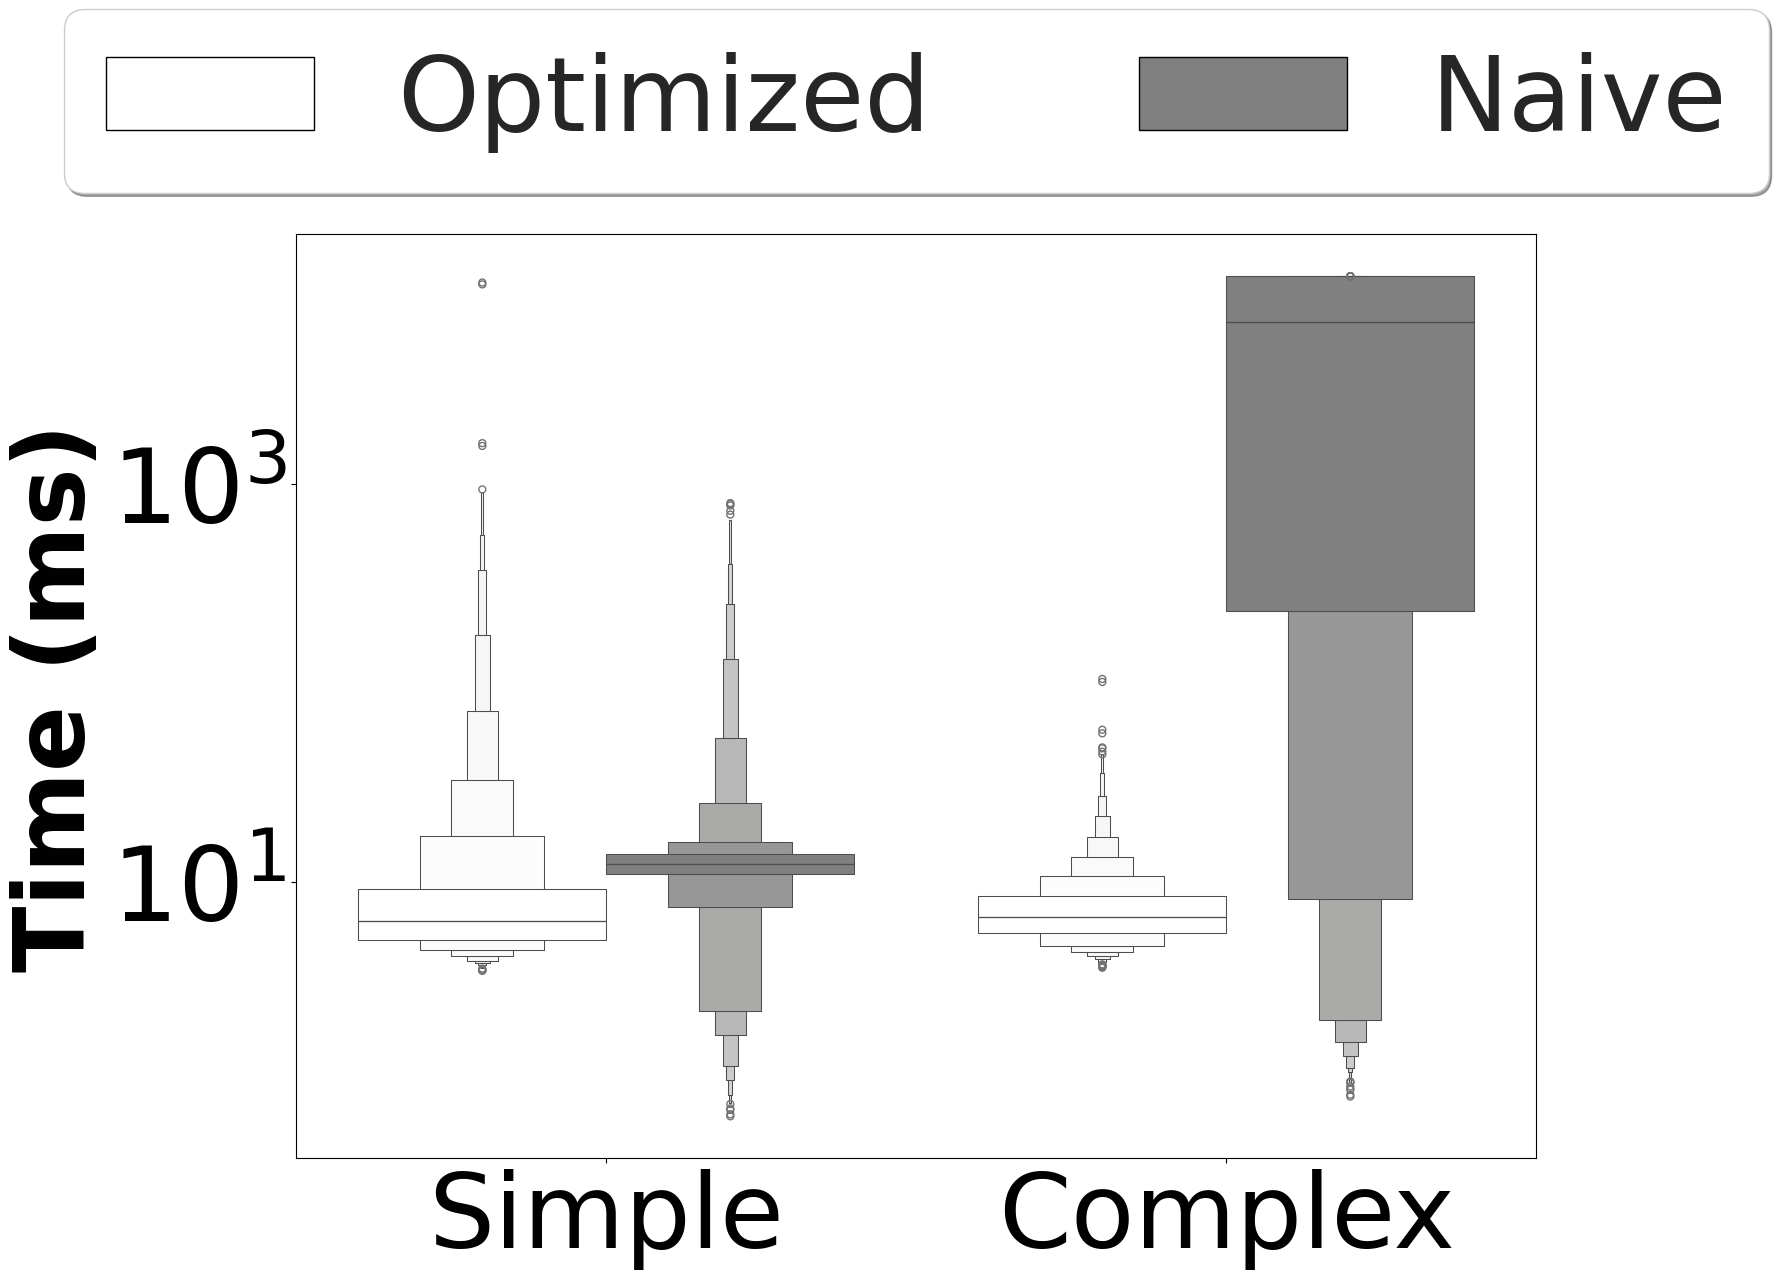

/tmp/ipykernel_9818/199703335.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


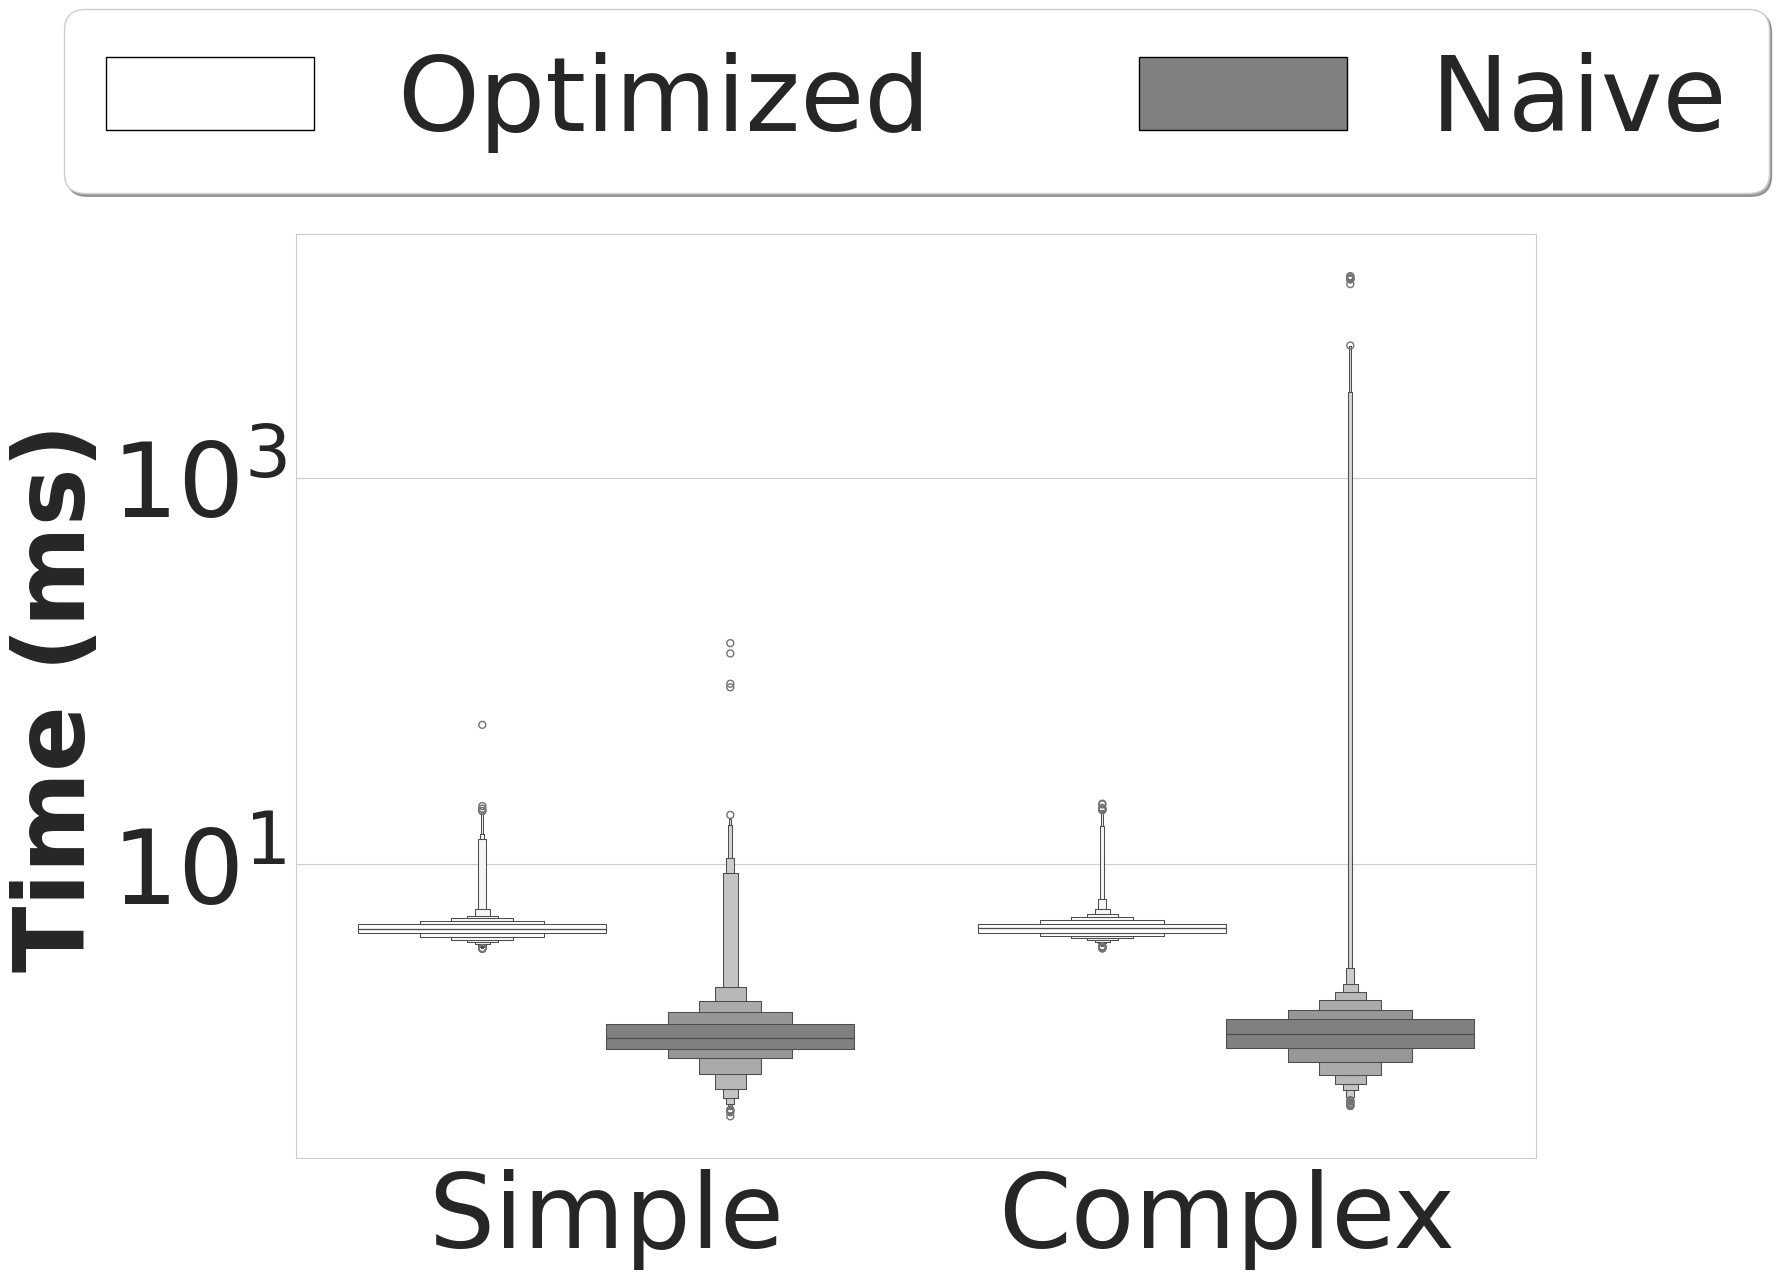

/tmp/ipykernel_9818/199703335.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


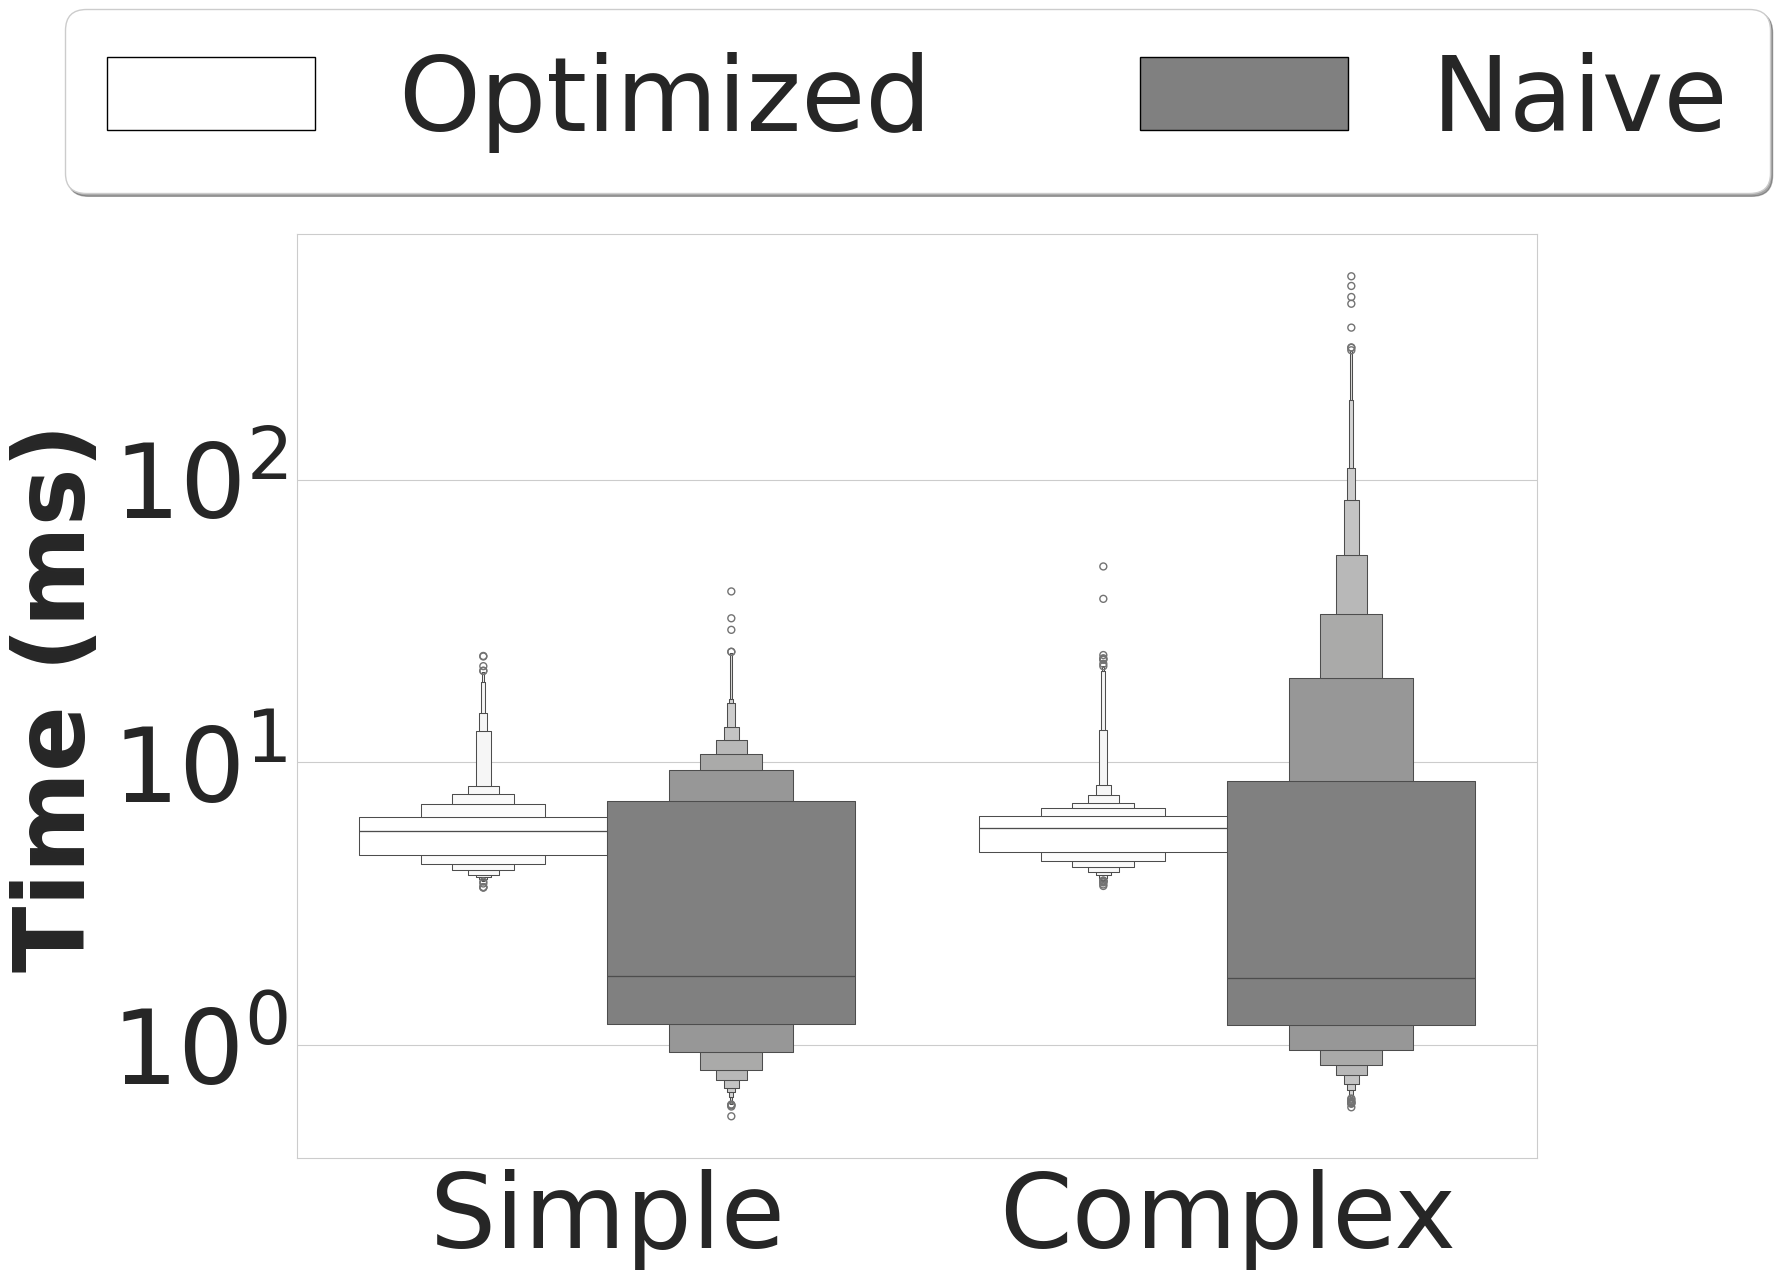

/tmp/ipykernel_9818/199703335.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


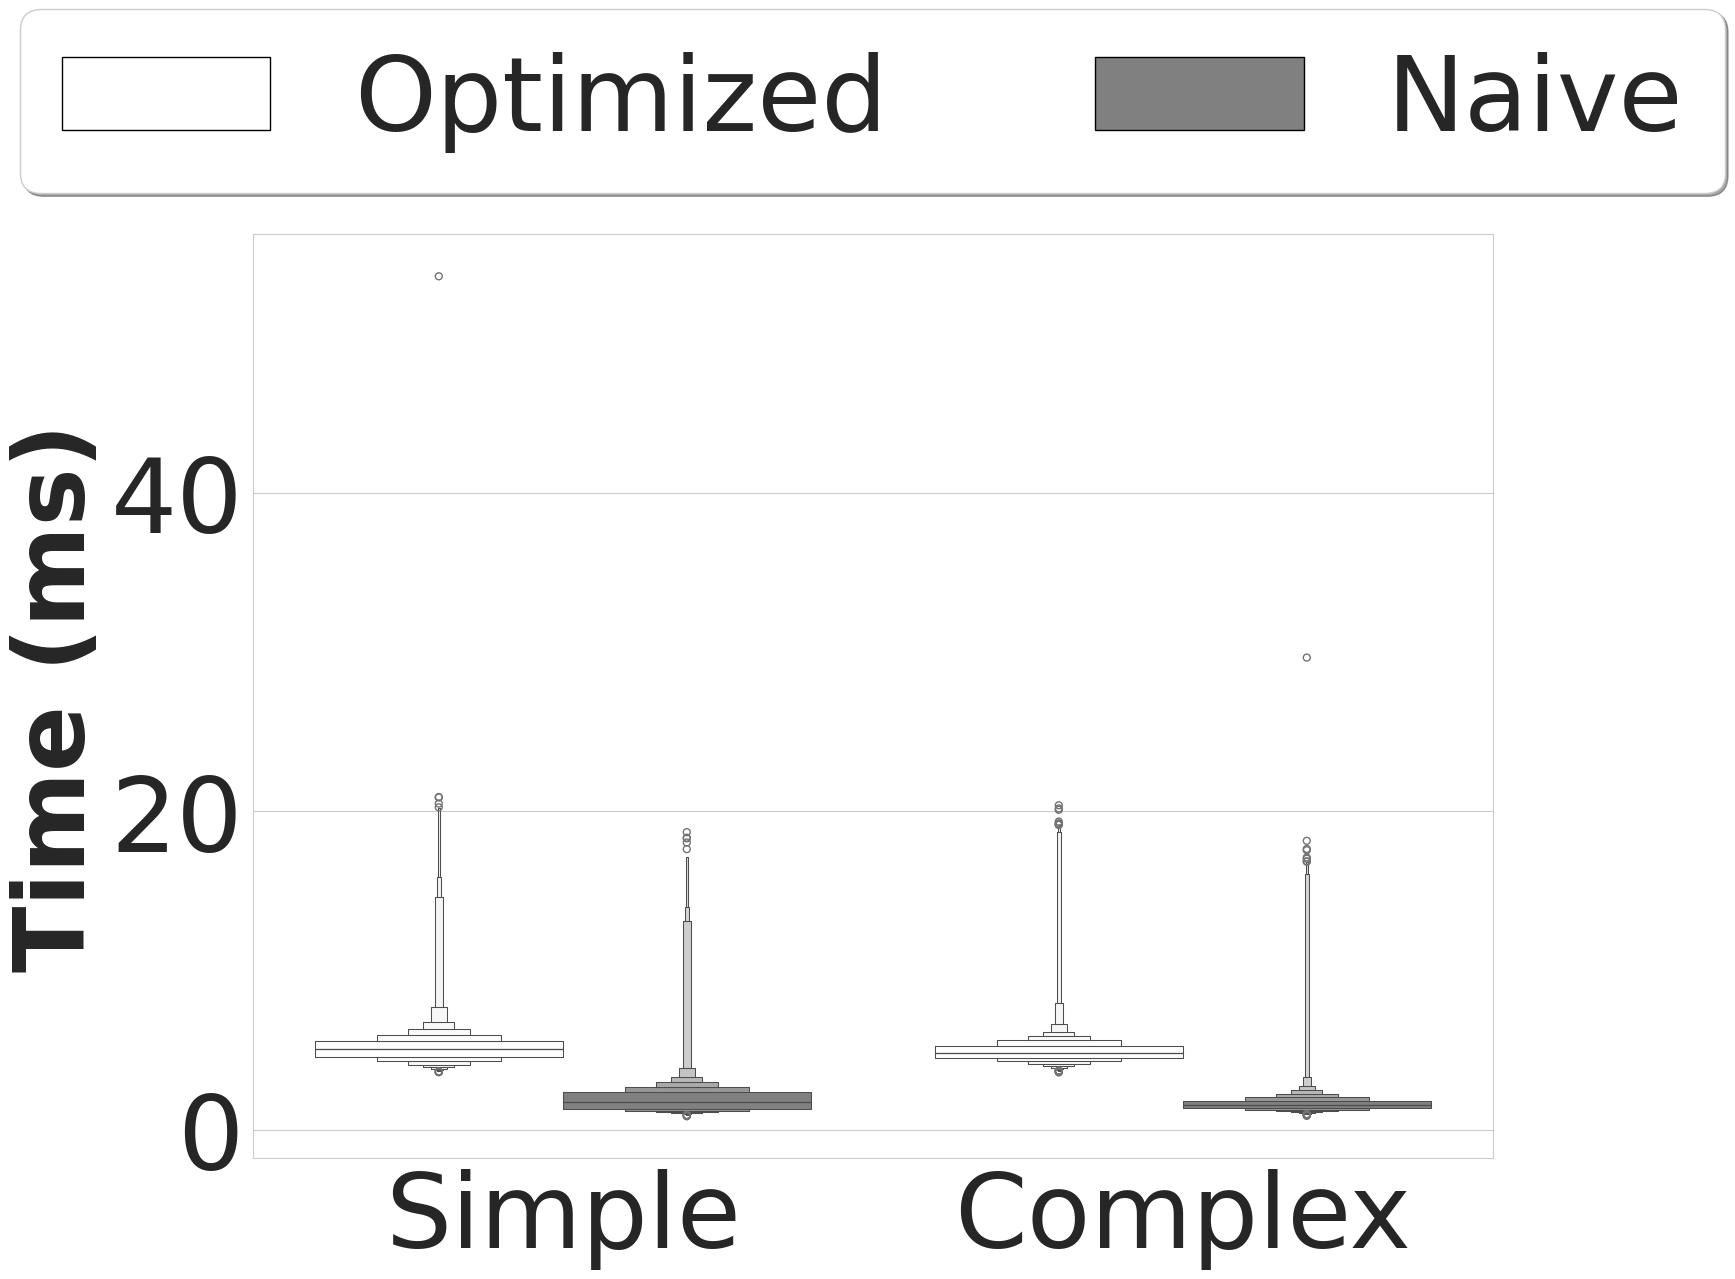

/tmp/ipykernel_9818/199703335.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


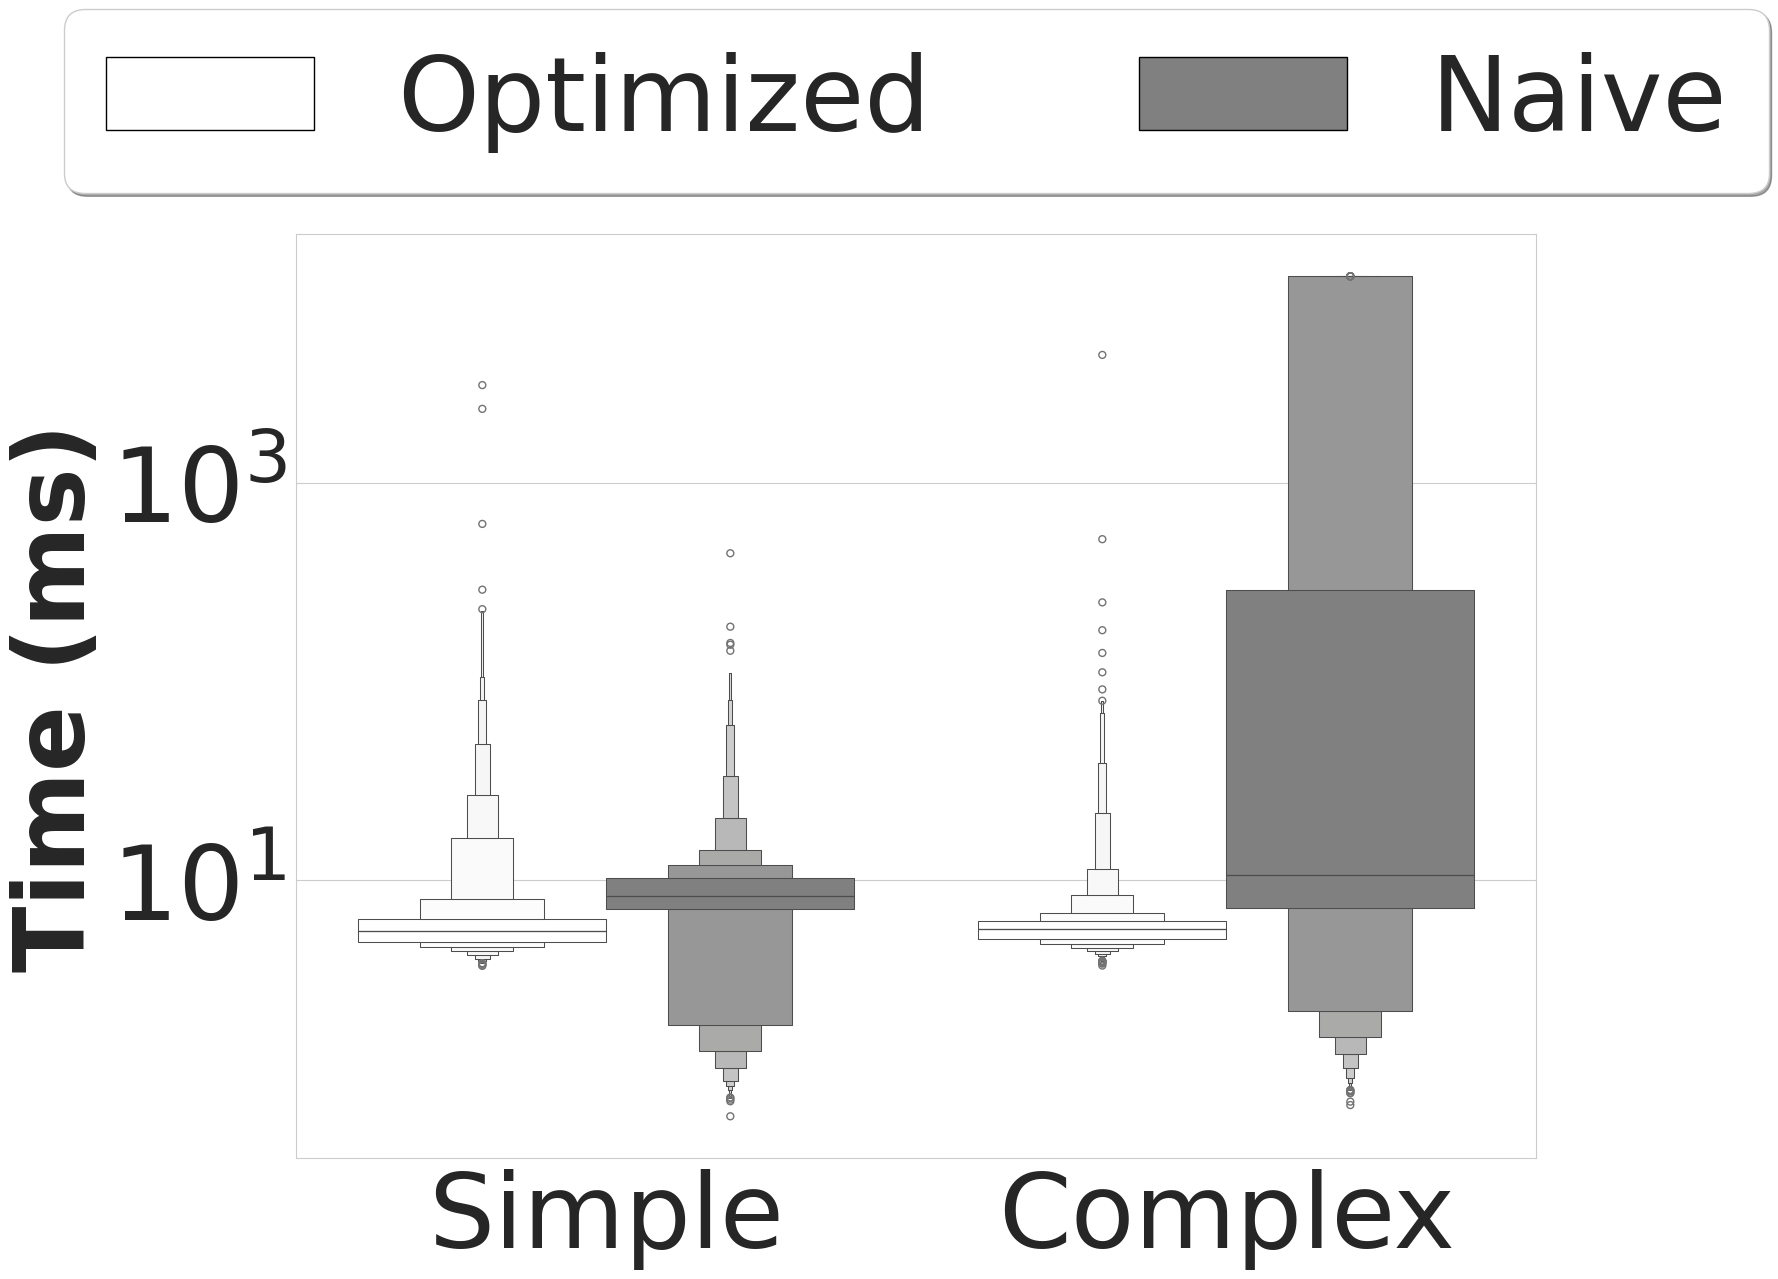

/tmp/ipykernel_9818/199703335.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


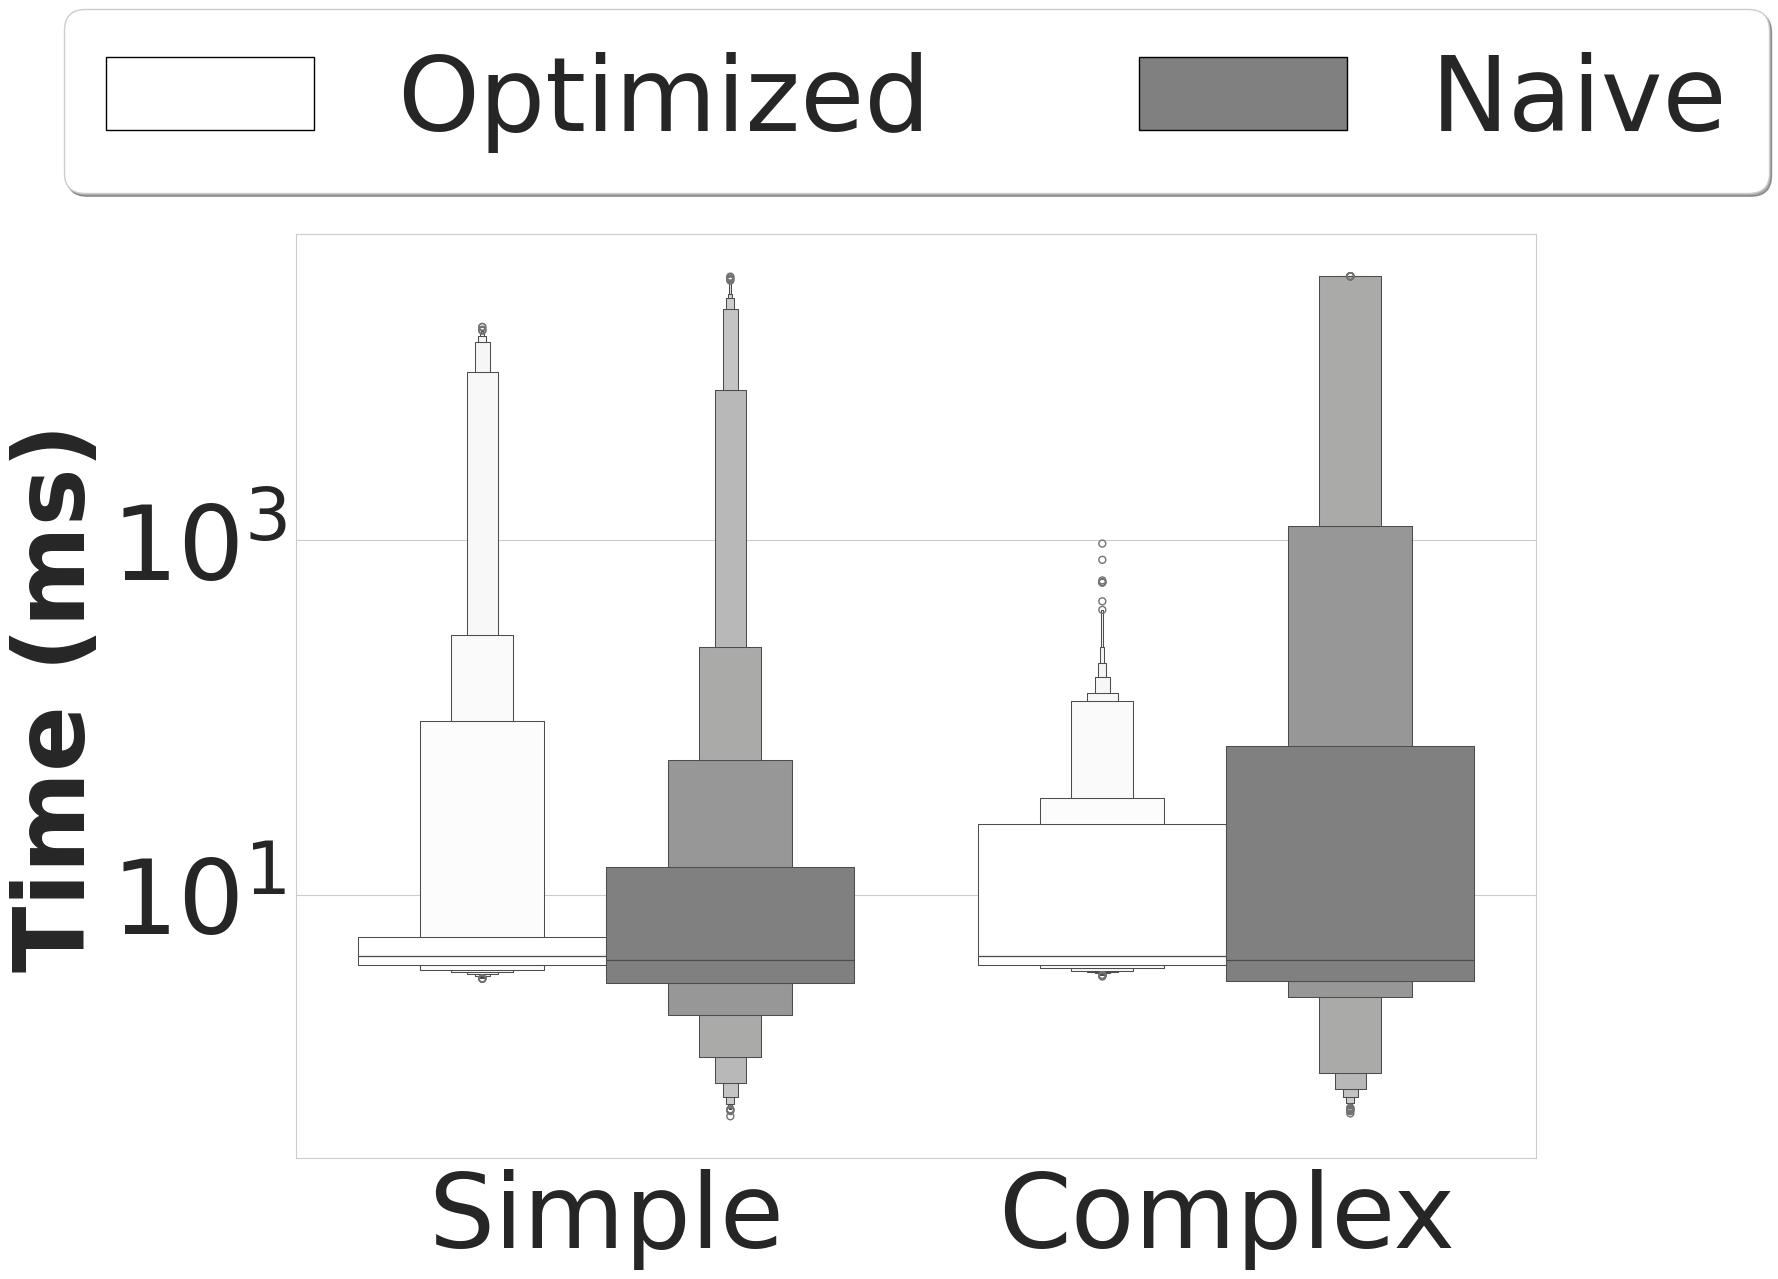

,Query,Data Constraint,Dataset,Time,IsTimeout,Constraint_Complexity
0,Q1,D1,Optimized,67.777438,False,Simple
1,Q1,D1,Optimized,18.429067,False,Simple
2,Q1,D1,Optimized,16.277072,False,Simple
3,Q1,D1,Optimized,14.179999,False,Simple
4,Q1,D1,Optimized,5.115664,False,Simple
...,...,...,...,...,...,...
11995,Q12,D5,Naive,7.238986,False,Complex
11996,Q12,D5,Naive,24.036976,False,Complex
11997,Q12,D5,Naive,4.709398,False,Complex
11998,Q12,D5,Naive,30966.055344,True,Complex


In [7]:
plot_time_distribution_by_constraint("ldbc10/ldbc10_statistic.pkl", "ldbc10-naive/ldbc10_naive_statistic.pkl", ds="LDBC10", timeout=10)
plot_time_distribution_by_constraint("ldbc01/ldbc01_statistic.pkl", "ldbc01-naive/ldbc01_naive_statistic.pkl", ds="LDBC01", timeout=10)
plot_time_distribution_by_constraint("paradise/icij_paradise_statistic.pkl", "paradise-naive/icij_paradise_naive_statistic.pkl", ds="Paradise", timeout=10)
plot_time_distribution_by_constraint("icij-leak/icij_leak_statistic.pkl", "icij-leak-naive/icij_leak_naive_statistic.pkl", ds="ICIJ", timeout=10)

plot_time_distribution_by_constraint("pokec/pokec_statistic.pkl", "pokec-naive/pokec_naive_statistic.pkl", ds="Pokec", timeout=10)
plot_time_distribution_by_constraint("telecom/telecom_statistic.pkl", "telecom-naive/telecom_naive_statistic.pkl", ds="Telecom", timeout=30)


In [13]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
    

# Alternative version with single plot but side-by-side bars
def plot_timeout_rate_by_constraint_single(path, path2, ds, name1="Optimized", name2="Naive", timeout=10):
    """
    Alternative version: Single plot with side-by-side bars for simple vs complex
    """
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q12
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:  # Skip RPQ
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare data
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        timeout_count = sum(1 for value in values if (value / 1000) > timeout)
        total_count = len(values)
        timeout_rate = (timeout_count / total_count) * 100 if total_count > 0 else 0
        
        plot_data.append({
            'Query': group,
            'Data Constraint': dtype,
            'Dataset': dataset_name,
            'TimeoutCount': timeout_count,
            'TotalCount': total_count,
            'TimeoutRate': timeout_rate
        })
    
    df = pd.DataFrame(plot_data)
    
    # Classify data constraints
    def classify_constraint(dtype):
        if dtype in ['D1', 'D2']:
            return 'Simple'
        elif dtype in ['D3', 'D4', 'D5']:
            return 'Complex'
        return 'Other'
    
    df['Constraint_Complexity'] = df['Data Constraint'].apply(classify_constraint)
    # Aggregate data by constraint complexity and dataset
    summary_df = df.groupby(['Constraint_Complexity', 'Dataset']).agg({
        'TimeoutCount': 'sum',
        'TotalCount': 'sum',
        'TimeoutRate': 'mean'
    }).reset_index()
    
    # Filter out 'Other' if any
    summary_df = summary_df[summary_df['Constraint_Complexity'].isin(['Simple', 'Complex'])]
    
    # Create single plot
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Set up positions for side-by-side bars
    x_pos = np.arange(2)  # Two groups: Simple and Complex
    bar_width = 0.35
    
    # Plot bars for each dataset within each constraint type
    for i, dataset_name in enumerate([name1, name2]):
        dataset_data = summary_df[summary_df['Dataset'] == dataset_name]
        print(dataset_name)
        positions = x_pos + (i * bar_width) - (bar_width / 2)
        heights = dataset_data['TimeoutRate'].values
        
        bars = ax.bar(positions, heights, bar_width, 
                     label=dataset_name, 
                     color='white' if i == 0 else 'grey',
                     edgecolor='black', linewidth=2)
        
        # Add value labels
        for bar, height in zip(bars, heights):
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=40, fontweight='bold')
    
    # Customize plot
    ax.set_ylabel('Timeout Rate (%)', fontsize=45, fontweight='bold')
    ax.tick_params(axis='y', labelsize=40,)
    ax.tick_params(axis='x', labelsize=40)
    
    # Set x-axis labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Complex', 'Simple'], fontsize=45)
    
    # Set y-axis limit
    max_rate = summary_df['TimeoutRate'].max()
    ax.set_ylim(0, max_rate * 1.2)
    ax.set_yticks(np.arange(0, 100, step=10))
    # Add legend
    ax.legend(loc='upper right', 
             ncol=1, fontsize=40, frameon=True, fancybox=True, shadow=True)
    
    # Add grid
    ax.grid(axis='y', alpha=0.3)
    
    # Add title
    
    plt.tight_layout()
    plt.savefig(f'figure/{ds}-timeout-rate-single.pdf', 
                format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()
    
    return summary_df



Optimized
Naive


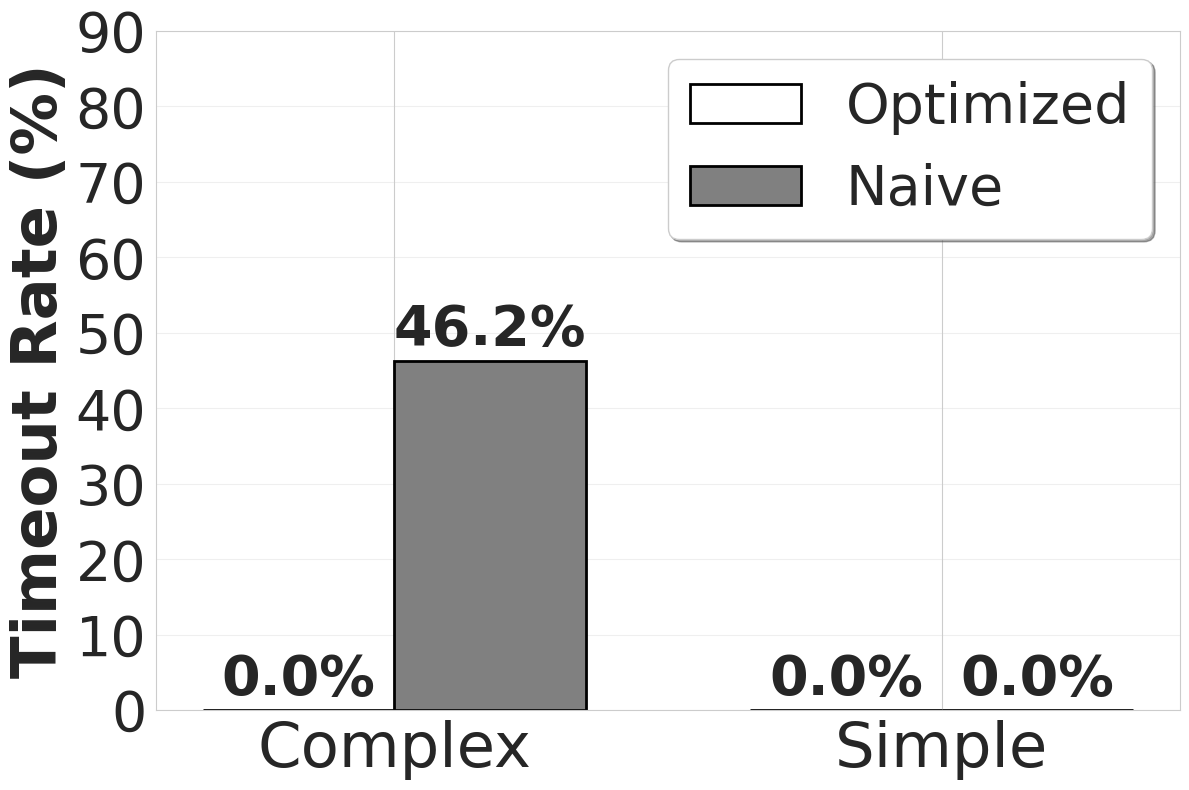

Optimized
Naive


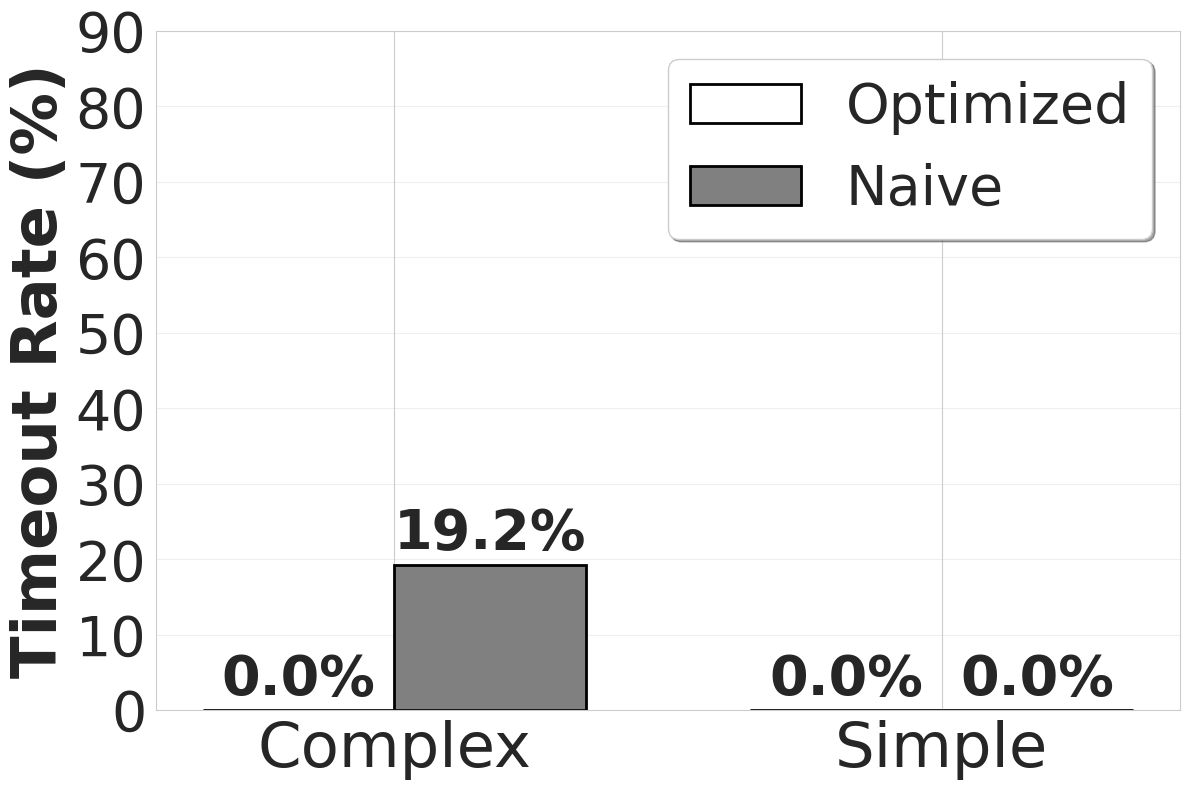

Optimized
Naive


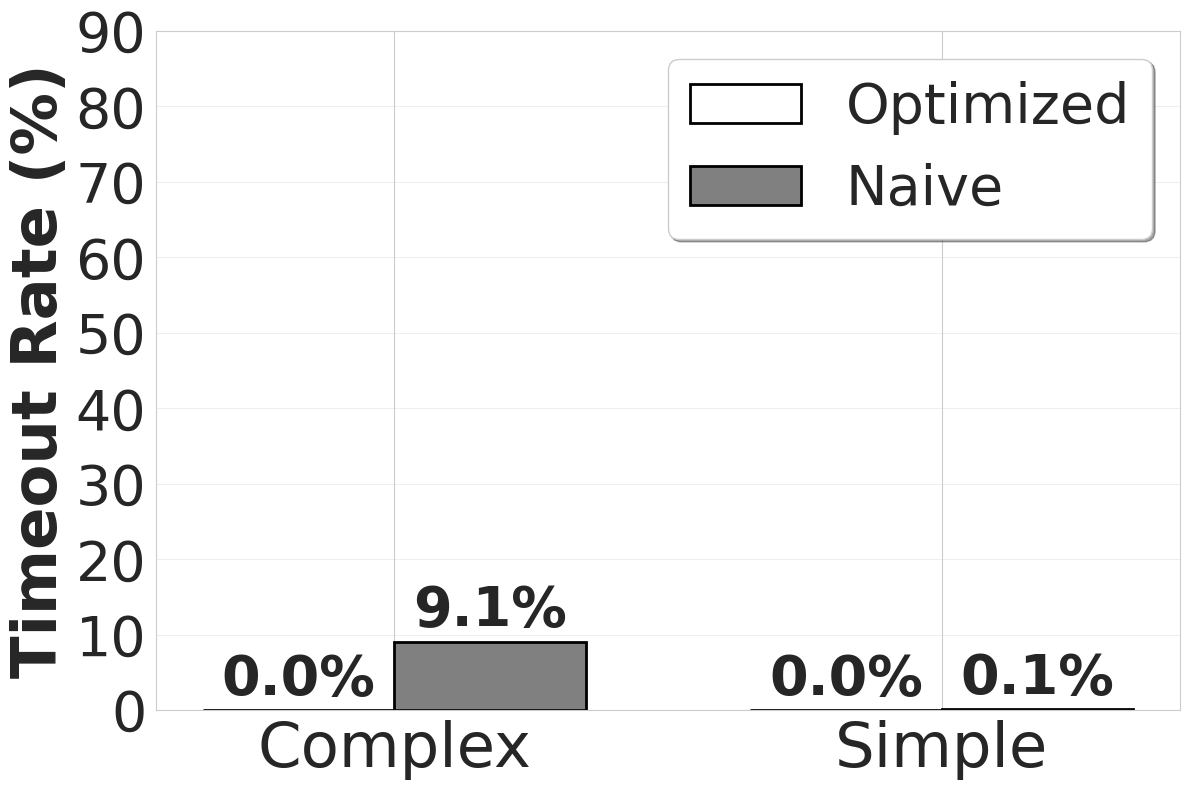

,Constraint_Complexity,Dataset,TimeoutCount,TotalCount,TimeoutRate
0,Complex,Naive,326,3600,9.055556
1,Complex,Optimized,0,3600,0.000000
2,Simple,Naive,3,2400,0.125000
3,Simple,Optimized,0,2400,0.000000


In [14]:
plot_timeout_rate_by_constraint_single("ldbc10/ldbc10_statistic.pkl", "ldbc10-naive/ldbc10_naive_statistic.pkl", 
                               ds="LDBC10", timeout=10)

plot_timeout_rate_by_constraint_single("pokec/pokec_statistic.pkl", "pokec-naive/pokec_naive_statistic.pkl", 
                               ds="Pokec", timeout=10)
plot_timeout_rate_by_constraint_single("telecom/telecom_statistic.pkl", "telecom-naive/telecom_naive_statistic.pkl", 
                               ds="Telecom", timeout=30)

In [8]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.ticker as ticker

def plot_single_dataset_boxplot(path, ds, name="Dataset", log_scale=True):
    # Load the dataset
    with open(path, "rb+") as f:
        data = pickle.loads(f.read())
    
    # Process the dataset
    data_groups = []
    for i in range(12):  # Q1-Q12
        id = 0
        for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
            if id == 0:
                id += 1
                continue
            values = list(map(lambda x: x, data[i*6 + id][2]))
            data_groups.append((f"Q{i+1}", dtype, name, values))
            id += 1

    # Prepare data for box plotting
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        for value in values:
            plot_data.append({
                'Query': group,
                'Data Constraint': dtype,
                'Dataset': dataset_name,
                'Time': value
            })
    
    df = pd.DataFrame(plot_data)
    
    # Create a single large figure
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.set_style("whitegrid")

    # Get current font sizes to calculate double size
    current_fontsize = plt.rcParams['font.size']
    double_fontsize = current_fontsize * 3

    # Create box plots for all queries (Q as x-axis)
    boxplot = sns.boxplot(data=df, x='Query', y='Time', 
                         hue='Data Constraint', ax=ax, showfliers=False,
                         palette='viridis', dodge=True)
    
    # Set titles and labels with larger font
    # ax.set_title(f"Runtime Distribution - {ds}", fontweight='bold', fontsize=double_fontsize * 1.2)
    ax.set_xlabel("")
    ax.set_ylabel("Time (ms)", fontsize=double_fontsize)
    
    # Increase tick label size
    ax.tick_params(axis='x', labelsize=double_fontsize * 0.9)
    ax.tick_params(axis='y', labelsize=double_fontsize * 0.9)
    
    # plt.setp(ax.get_xticklabels())
    
    # Check for log scale
    max_time_val = df['Time'].max()
    min_time_val = df[df['Time'] > 0]['Time'].min()  # Exclude zeros
    if log_scale and max_time_val > 0 and min_time_val > 0 and max_time_val / min_time_val > 1000:
        ax.set_yscale("log")
        # ax.set_title(f"Runtime Distribution - {ds} (log scale)", fontweight='bold', fontsize=double_fontsize * 1.2)
    else:
        # Reduce distance between y-axis ticks by half for linear scale
        y_min, y_max = ax.get_ylim()
        current_ticks = ax.get_yticks()
        
        if len(current_ticks) > 1:
            current_spacing = current_ticks[1] - current_ticks[0]
            new_spacing = current_spacing / 2
            
            # Make sure we don't create too many ticks
            max_ticks = 20
            num_ticks = int((y_max - y_min) / new_spacing) + 1
            
            if num_ticks <= max_ticks:
                new_ticks = np.arange(round(y_min / new_spacing) * new_spacing, 
                                     round(y_max / new_spacing) * new_spacing + new_spacing, 
                                     new_spacing)
                ax.set_yticks(new_ticks)
            else:
                # Use automatic locator if too many ticks would be created
                ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=max_ticks))

    # Create legend for data constraints only
    data_constraints = ["D1", "D2", "D3", "D4", "D5"]
    colors = plt.cm.viridis(np.linspace(0, 1, len(data_constraints)))
    
    legend_elements = []
    for constraint, color in zip(data_constraints, colors):
        legend_elements.append(
            Patch(facecolor=color, label=f'{constraint}')
        )
    

    legend = ax.legend(handles=legend_elements, 
                      loc='upper center',  # Changed to upper right corner
                      bbox_to_anchor=(0.5, 1.2),  # Slightly inside the corner
                      ncol=5,  # Single column for corner placement
                      fontsize=double_fontsize ,  # Even larger text for legend
                      frameon=True, 
                      fancybox=True, 
                      shadow=True,
                      title="Data Constraints", 
                      title_fontsize=double_fontsize  )  # Larger title
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.savefig(f'figure/{ds}-query-x-axis-boxplot.pdf', 
                format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()


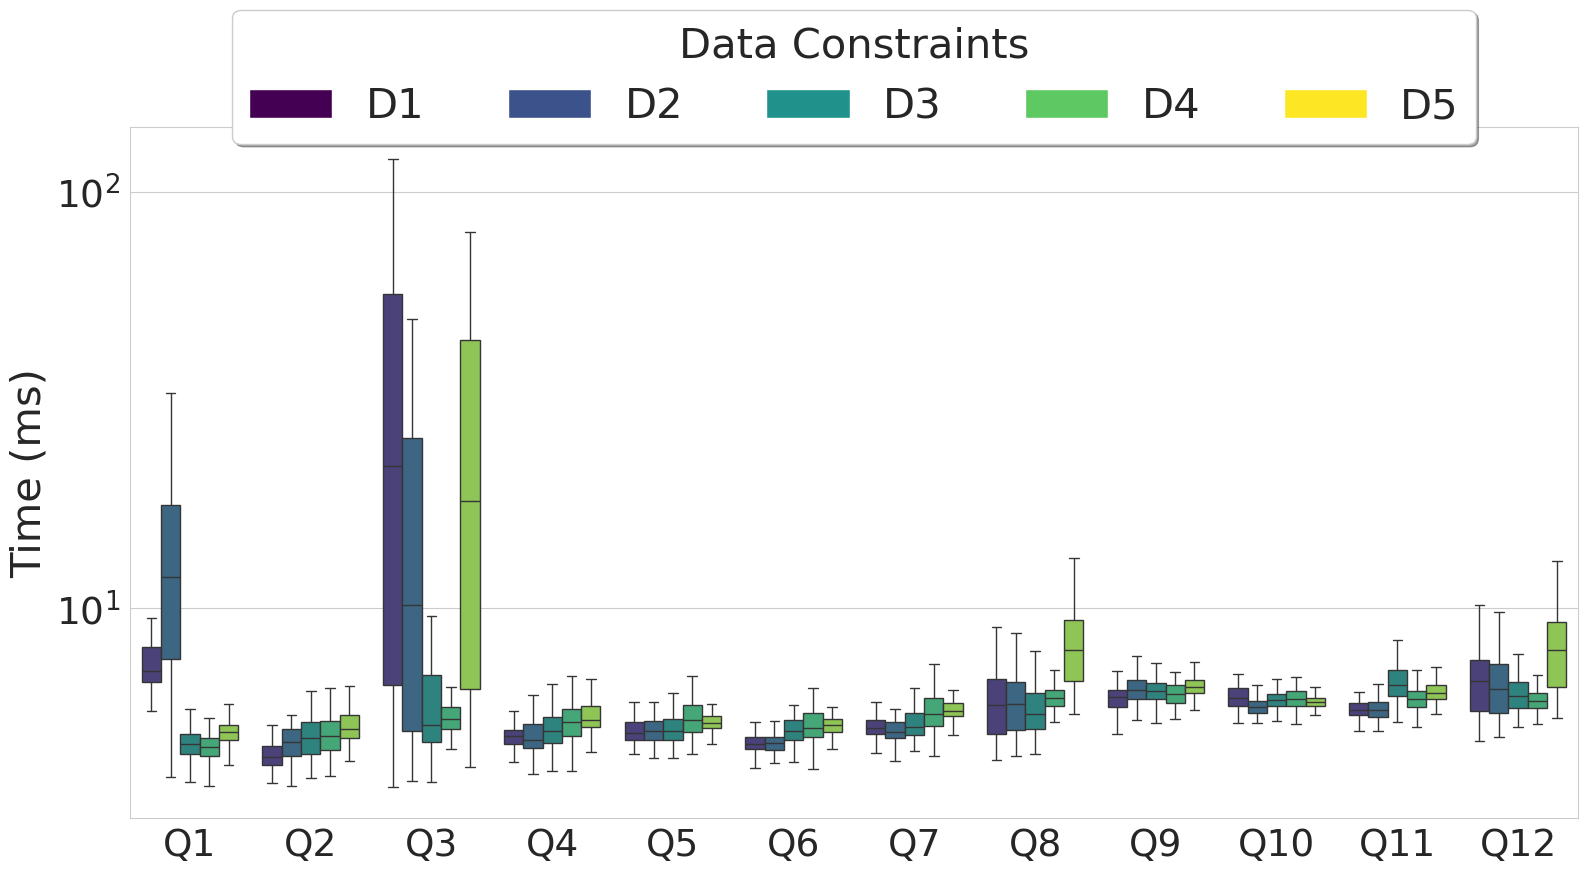

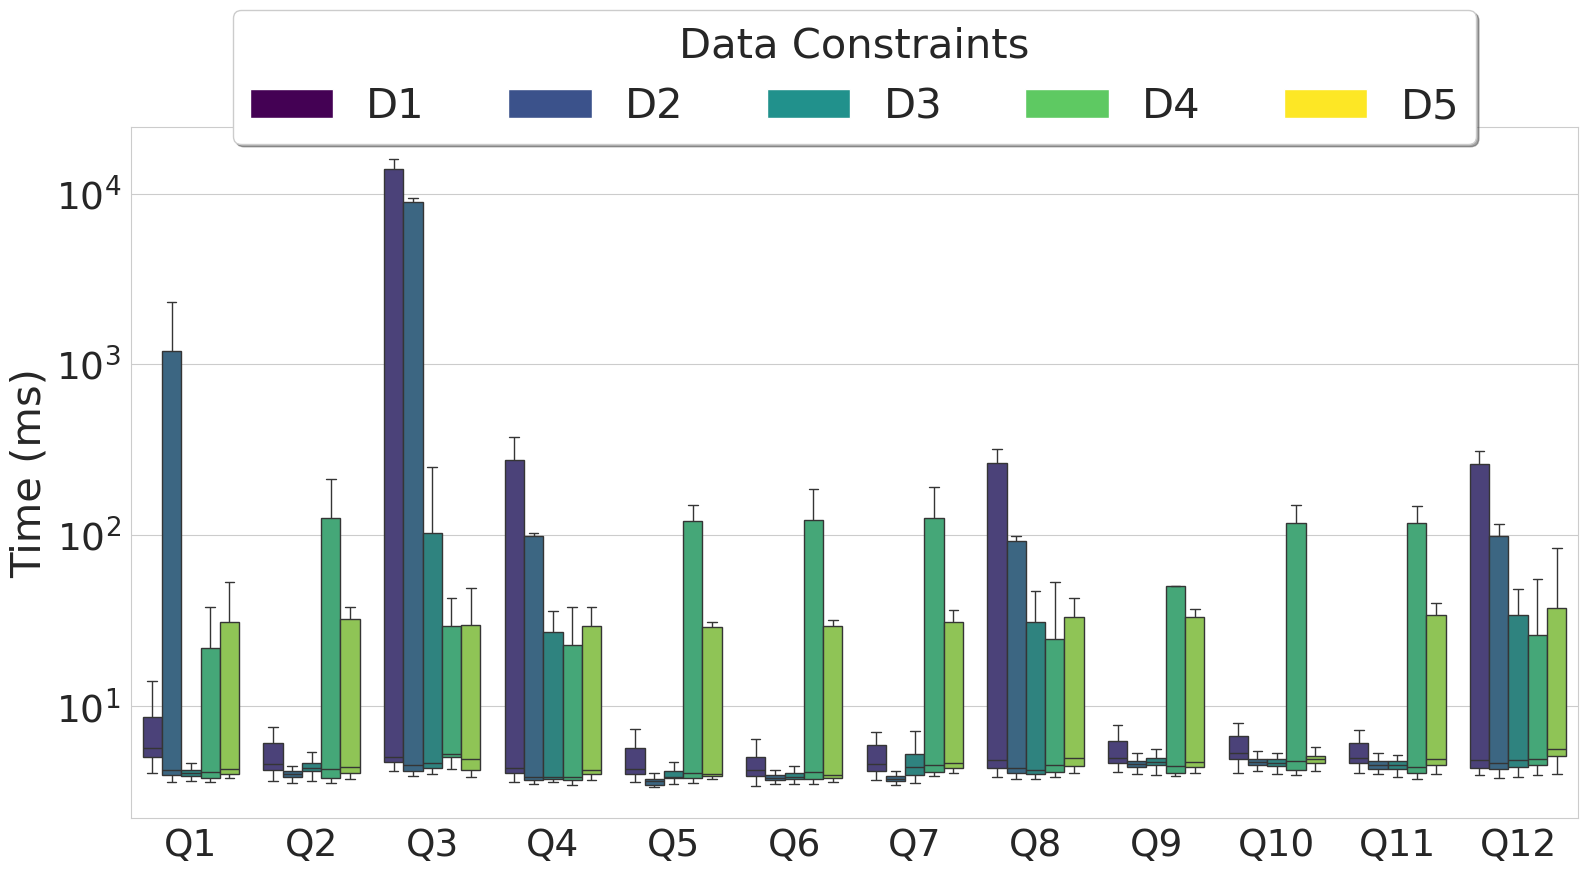

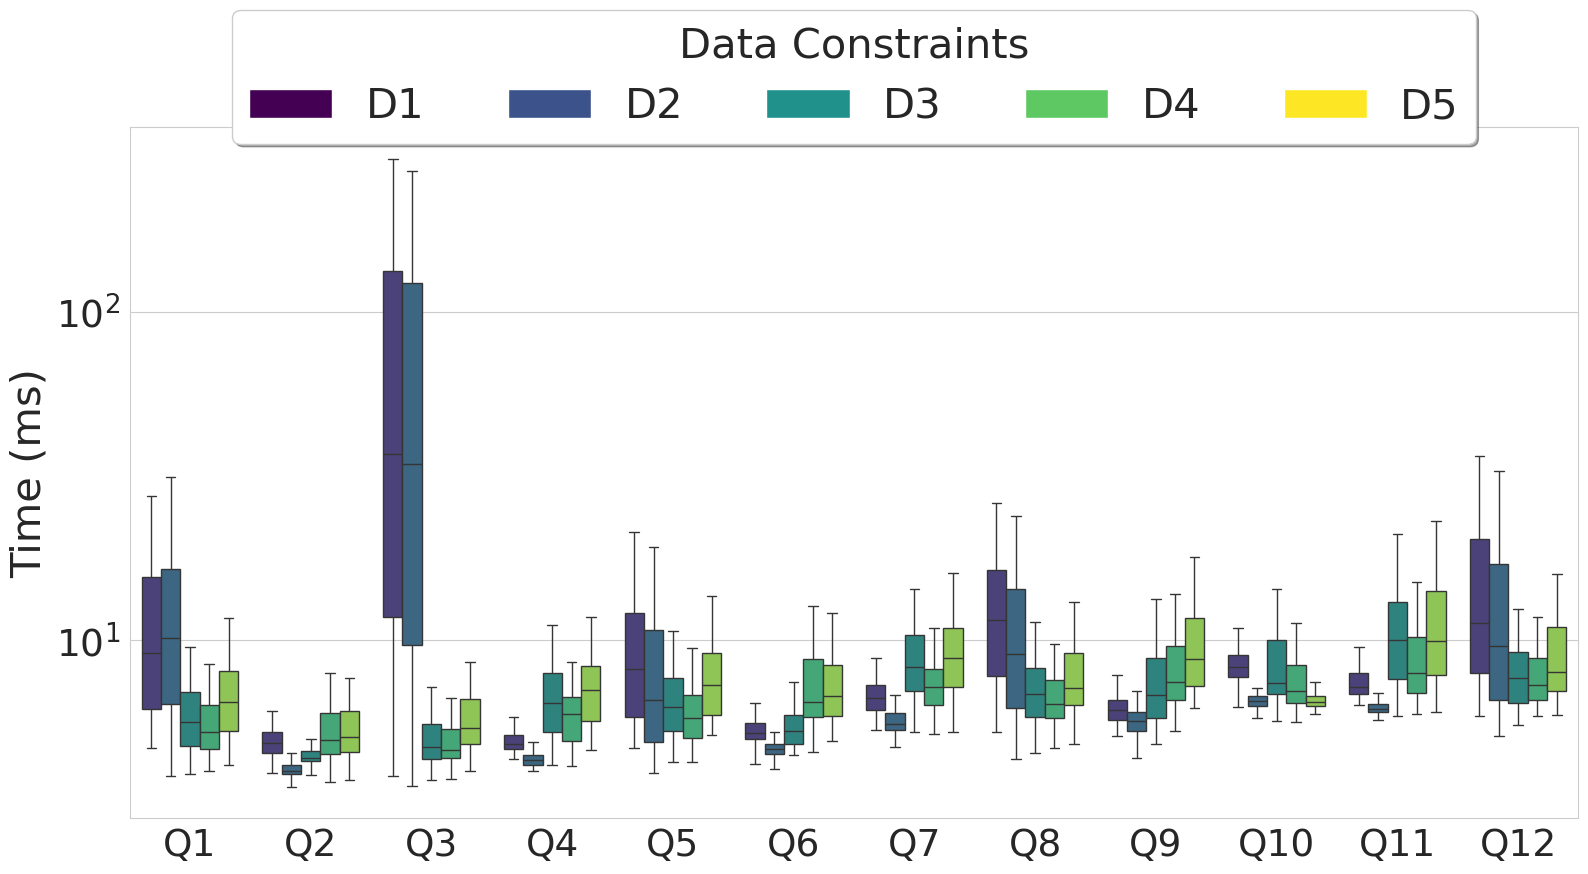

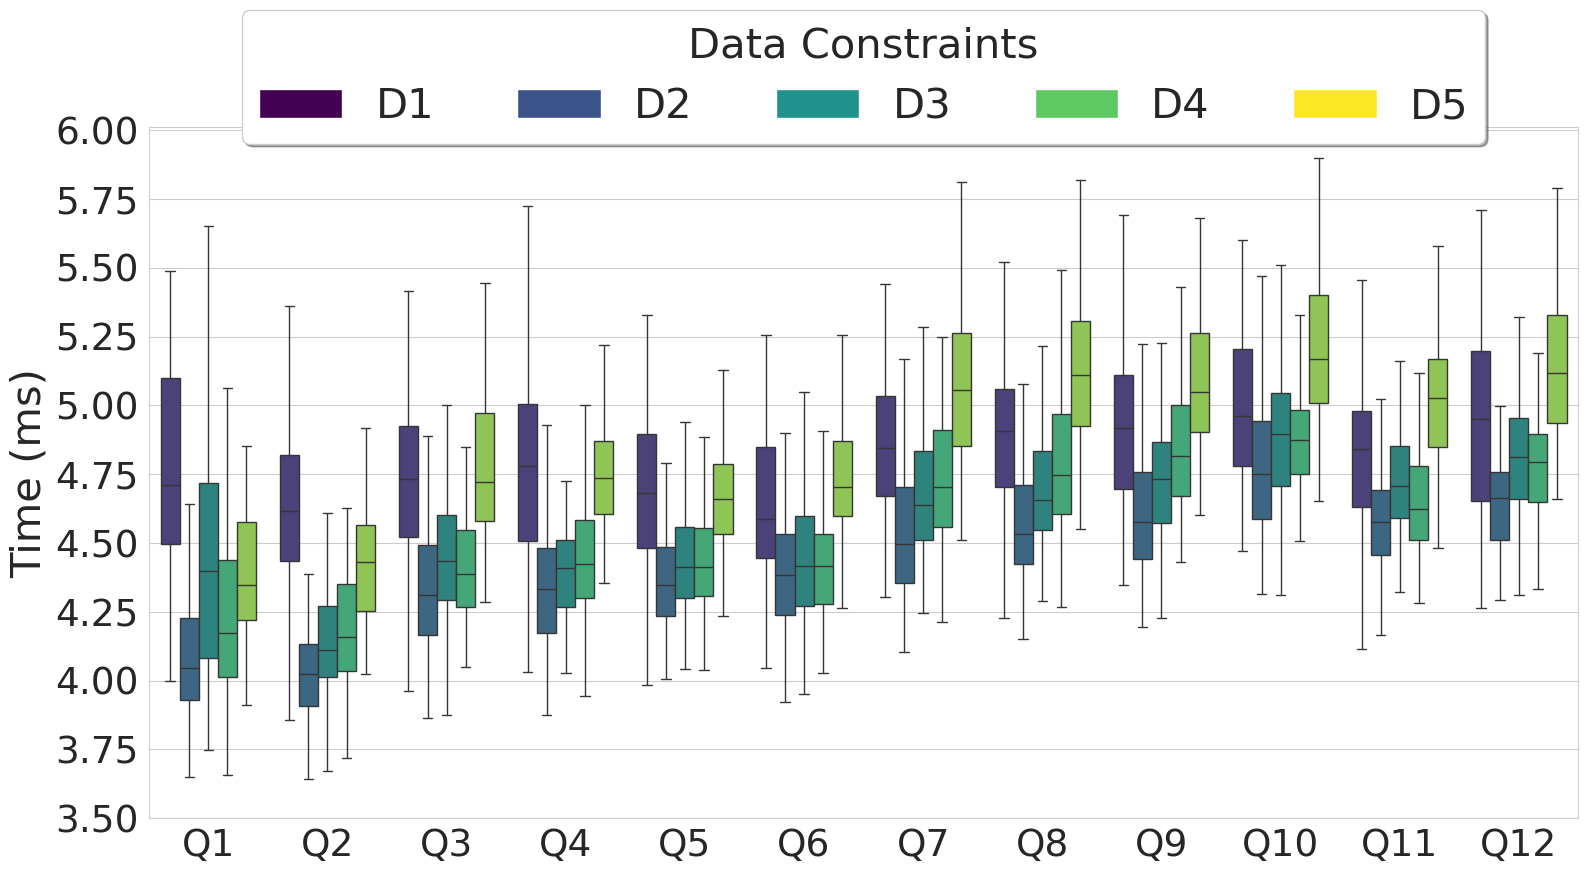

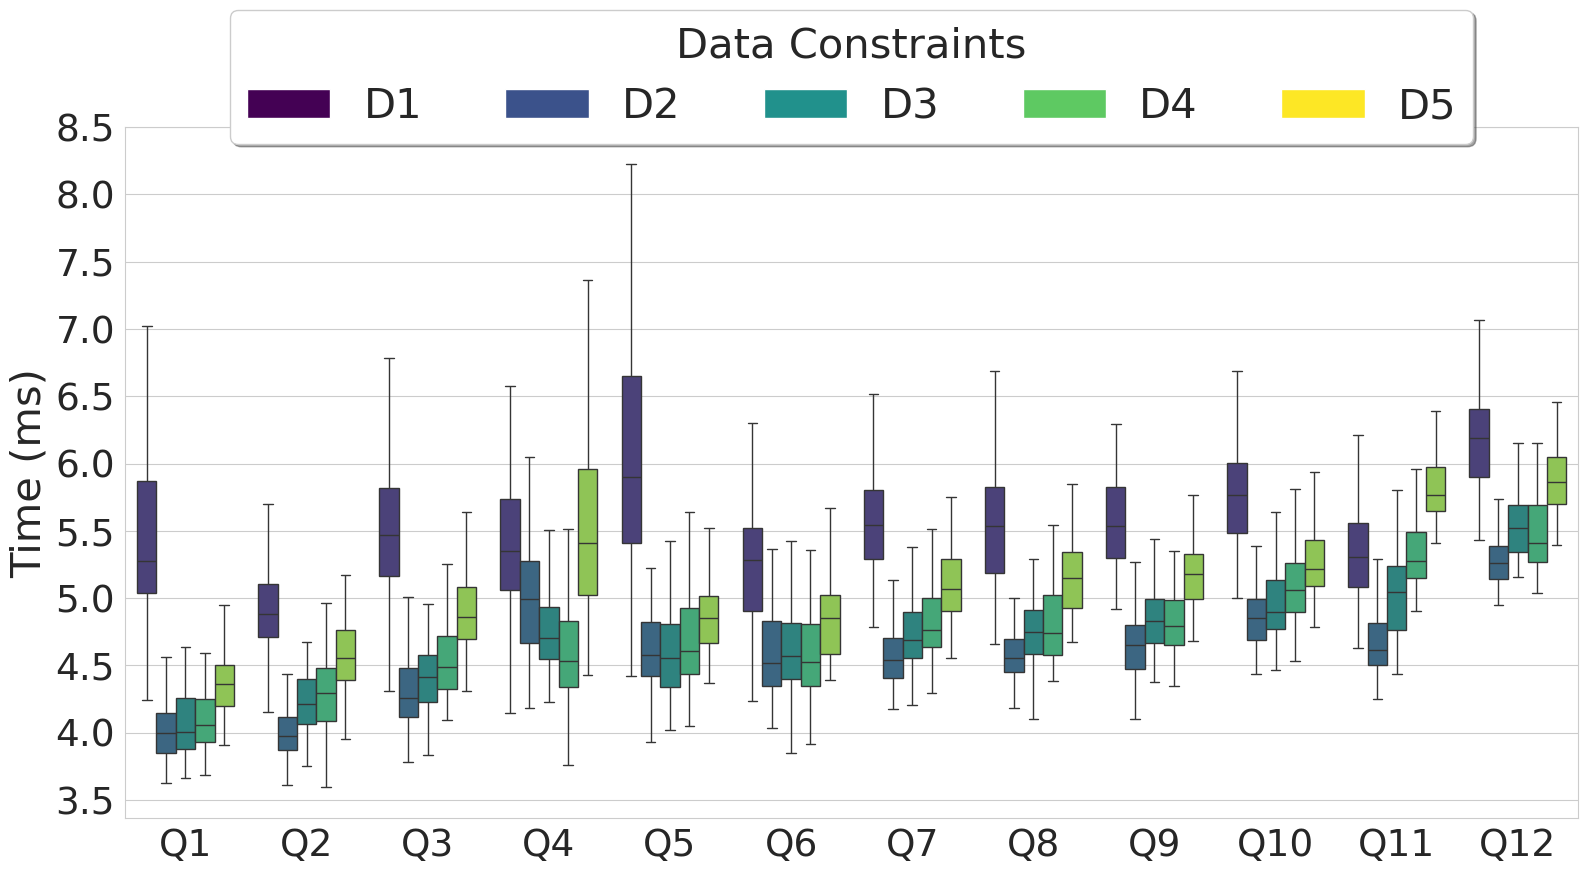

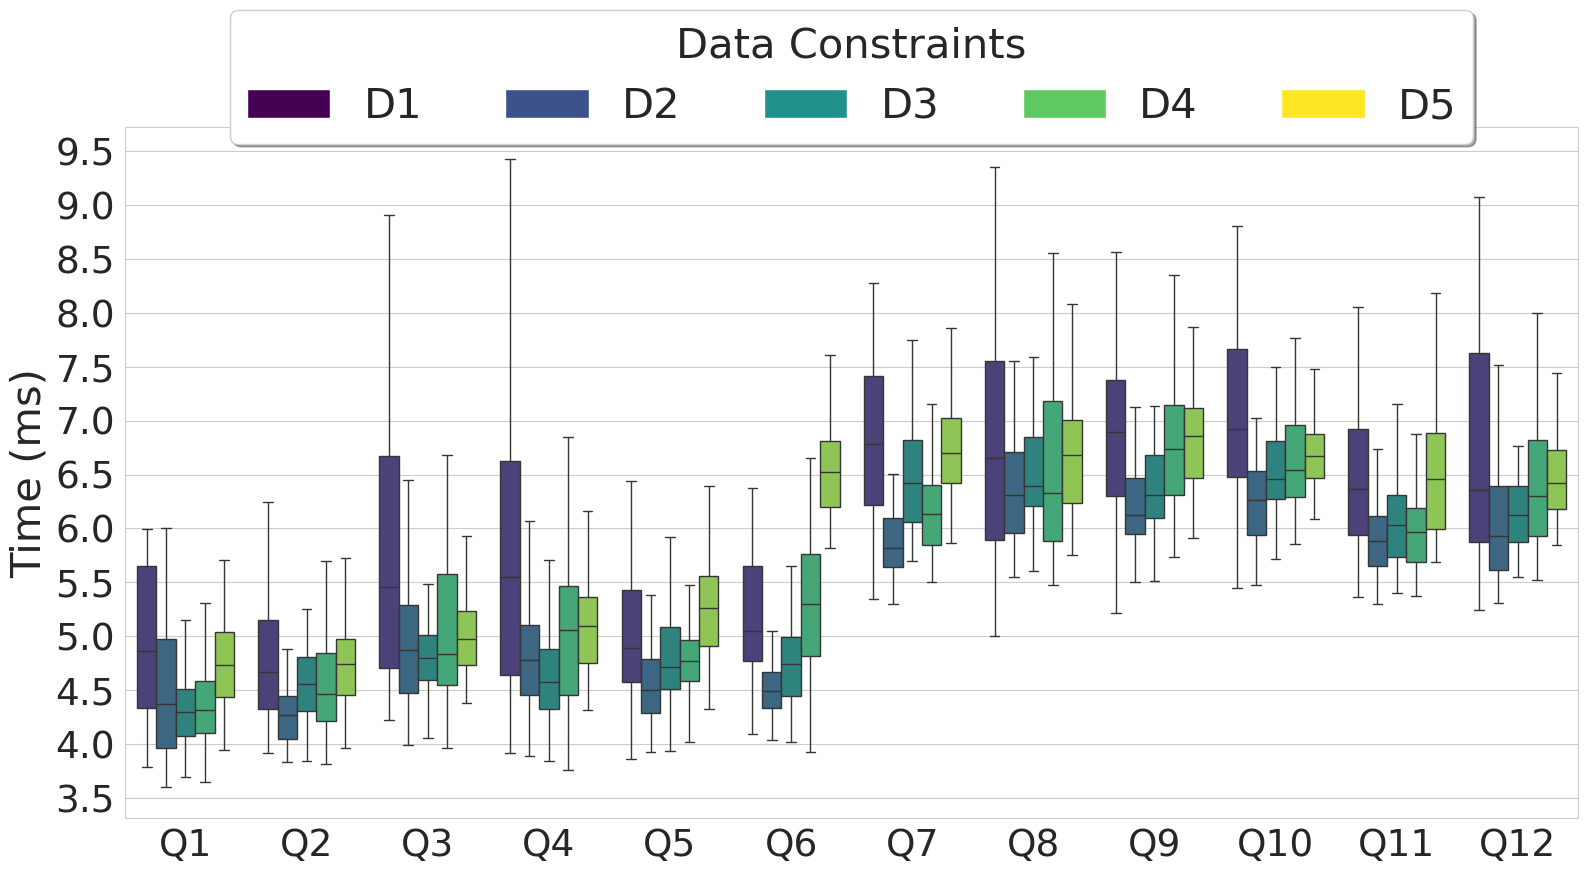

In [10]:
plot_single_dataset_boxplot("pokec/pokec_statistic.pkl", ds="Pokec")
plot_single_dataset_boxplot("telecom/telecom_statistic.pkl", ds="Telecom")
plot_single_dataset_boxplot("ldbc10/ldbc10_statistic.pkl", ds="LDBC10")
plot_single_dataset_boxplot("ldbc01/ldbc01_statistic.pkl", ds="LDBC01")
plot_single_dataset_boxplot("icij-leak/icij_leak_statistic.pkl", ds="ICIJ")
plot_single_dataset_boxplot("paradise/icij_paradise_statistic.pkl", ds="Paradise")





In [11]:
optimized_paths = ["ldbc01/ldbc01_statistic.pkl", 
         "ldbc10/ldbc10_statistic.pkl", 
         "pokec/pokec_statistic.pkl",
         "telecom/telecom_statistic.pkl",
            "paradise/icij_paradise_statistic.pkl",
            "icij-leak/icij_leak_statistic.pkl"]
        
naive_paths = ["ldbc01-naive/ldbc01_naive_statistic.pkl", 
         "ldbc10-naive/ldbc10_naive_statistic.pkl", 
         "pokec-naive/pokec_naive_statistic.pkl",
         "telecom-naive/telecom_naive_statistic.pkl",
            "paradise-naive/icij_paradise_naive_statistic.pkl",
            "icij-leak-naive/icij_leak_naive_statistic.pkl"]

dataset_names = ["LDBC01", "LDBC10", "Pokec", "Telecom", "ICIJ-Paradise", "ICIJ-Leak"]


In [3]:
import pickle 
import numpy as np
with open("ldbc10-naive/ldbc10_naive_statistic.pkl","rb+") as f:
    data_ytb = pickle.loads(f.read()) 


for i in data_ytb:
    print(f"{i[1]} query, the max mem is {format(np.max(i[3]),'.3f')} mb, the average mem is {format(np.mean(i[3]),'.3f')} mb")

REGEX Q0 query, the max mem is 1061.250 mb, the average mem is 1061.250 mb
RDPQ Q11 query, the max mem is 1461.562 mb, the average mem is 1461.562 mb
RDPQ Q12 query, the max mem is 1472.031 mb, the average mem is 1472.031 mb
RDPQ Q13 query, the max mem is 1707.973 mb, the average mem is 1707.973 mb
RDPQ Q14 query, the max mem is 2406.641 mb, the average mem is 2406.641 mb
RDPQ Q15 query, the max mem is 2982.297 mb, the average mem is 2982.297 mb
REGEX Q1 query, the max mem is 2982.922 mb, the average mem is 2982.922 mb
RDPQ Q21 query, the max mem is 2983.859 mb, the average mem is 2983.859 mb
RDPQ Q22 query, the max mem is 2983.859 mb, the average mem is 2983.859 mb
RDPQ Q23 query, the max mem is 2983.859 mb, the average mem is 2983.859 mb
RDPQ Q24 query, the max mem is 3266.164 mb, the average mem is 3266.164 mb
RDPQ Q25 query, the max mem is 3444.164 mb, the average mem is 3444.164 mb
REGEX Q2 query, the max mem is 3444.164 mb, the average mem is 3444.164 mb
RDPQ Q31 query, the max m

In [12]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel, wilcoxon, pearsonr

def plot_dataset_memory_comparison(optimized_paths, dataset_names, output_name, 
                                  graph_sizes=None, unit='MB'):
    """
    Plot memory usage comparison between datasets with statistical tests
    and correlation analysis with graph sizes
    
    Parameters:
    optimized_paths: list of file paths to optimized algorithm pickle files
    dataset_names: list of dataset names for comparison
    output_name: name for output file
    graph_sizes: dict with dataset names as keys and |V|+|E| as values
    unit: memory unit ('B', 'KB', 'MB', 'GB')
    """
    
    # Load all datasets
    optimized_data = []
    
    for path in optimized_paths:
        with open(path, "rb+") as f:
            data = pickle.loads(f.read())
            optimized_data.append(data)
    
    # Process memory usage - separate RPQ and D constraints
    dataset_stats = []
    detailed_memory_data = []  # Store detailed data for statistical tests
    
    for dataset_idx, (data, dataset_name) in enumerate(zip(optimized_data, dataset_names)):
        rpq_memory_values = []
        d_memory_values = []
        query_memory_data = []  # Store memory data per query for statistical tests
        
        # Collect memory values for each query
        for i in range(12):  # Q1-Q12
            query_rpq_memory = []
            query_d_memory = []
            
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                memory_data = data[i*6 + id][3]  # Third domain contains memory usage
                if id == 0:  # RPQ
                    rpq_memory_values.append(memory_data)
                    query_rpq_memory.append(memory_data)
                else:  # D constraints
                    d_memory_values.append(memory_data)
                    query_d_memory.append(memory_data)
                
                id += 1
            
            # Store per-query data for statistical tests
            query_memory_data.append({
                'query': f'Q{i+1}',
                'rpq_memory': query_rpq_memory[0] if query_rpq_memory else 0,
                'd_memory_mean': np.mean(query_d_memory) if query_d_memory else 0,
                'd_memory_values': query_d_memory
            })
        print(query_d_memory)
        print(query_rpq_memory)        
        # Convert to appropriate unit
        def convert_units(values):
            values = np.array(values)
            if unit == 'KB':
                return values * 1024
            elif unit == 'MB':
                return values 
            elif unit == 'GB':
                return values / 1024
            return values
        
        rpq_memory_values = convert_units(rpq_memory_values)
        d_memory_values = convert_units(d_memory_values)
        
        # Statistical test for each query: RPQ vs D constraints
        statistical_results = []
        for query_data in query_memory_data:
            if len(query_data['d_memory_values']) > 0:
                # Convert D values to appropriate unit
                d_values = convert_units(query_data['d_memory_values'])
                
                # Paired t-test (RPQ vs mean of D constraints for this query)
                t_stat, p_value = ttest_rel([query_data['rpq_memory']], 
                                           [np.mean(d_values)])
                
                # Also Wilcoxon signed-rank test for non-parametric comparison
                if len(d_values) > 1:
                    wilcoxon_stat, wilcoxon_p = wilcoxon([query_data['rpq_memory']] * len(d_values), 
                                                         d_values)
                else:
                    wilcoxon_stat, wilcoxon_p = np.nan, np.nan
                
                statistical_results.append({
                    'query': query_data['query'],
                    'rpq_memory': query_data['rpq_memory'],
                    'd_memory_mean': np.mean(d_values),
                    't_statistic': t_stat,
                    'p_value': p_value,
                    'wilcoxon_stat': wilcoxon_stat,
                    'wilcoxon_p': wilcoxon_p,
                    'significant': p_value < 0.05
                })
        
        # Calculate overall statistics
        dataset_stats.append({
            'Dataset': dataset_name,
            'RPQ Max Memory': np.max(rpq_memory_values) if len(rpq_memory_values) > 0 else 0,
            'RPQ Average Memory': np.mean(rpq_memory_values) if len(rpq_memory_values) > 0 else 0,
            'D Max Memory': np.max(d_memory_values) if len(d_memory_values) > 0 else 0,
            'D Average Memory': np.mean(d_memory_values) if len(d_memory_values) > 0 else 0,
            'Memory Difference (D-RPQ)': np.mean(d_memory_values) - np.mean(rpq_memory_values),
            'Statistical Results': statistical_results,
            'All Memory Values': np.concatenate([rpq_memory_values, d_memory_values]),
            'RPQ Values': rpq_memory_values,
            'D Values': d_memory_values
        })
        
        detailed_memory_data.append({
            'dataset': dataset_name,
            'query_data': query_memory_data,
            'rpq_values': rpq_memory_values,
            'd_values': d_memory_values
        })
    
    # Create DataFrame
    df = pd.DataFrame(dataset_stats)
    
    # Task 1: Statistical tests and visualization for RPQ vs D memory usage
    plot_rpq_vs_d_comparison(detailed_memory_data, dataset_names, output_name, unit)
    
    # Task 2: Correlation analysis with graph sizes
    if graph_sizes:
        plot_memory_vs_graph_size_correlation(dataset_stats, graph_sizes, output_name, unit)
    
    return df, detailed_memory_data

def plot_rpq_vs_d_comparison(detailed_data, dataset_names, output_name, unit):
    """Plot comparison between RPQ and D memory usage with statistical significance"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})
    
    # Prepare data for plotting
    plot_data = []
    for dataset_idx, data in enumerate(detailed_data):
        for query_data in data['query_data']:
            plot_data.append({
                'Dataset': data['dataset'],
                'Query': query_data['query'],
                'RPQ Memory': query_data['rpq_memory'],
                'D Memory Mean': query_data['d_memory_mean'],
                'Memory Difference': query_data['d_memory_mean'] - query_data['rpq_memory']
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Plot 1: Boxplot of RPQ vs D memory usage by dataset
    melted_df = plot_df.melt(id_vars=['Dataset', 'Query'], 
                           value_vars=['RPQ Memory', 'D Memory Mean'],
                           var_name='Memory Type', value_name=f'Memory ({unit})')
    
    sns.boxplot(data=melted_df, x='Dataset', y=f'Memory ({unit})', hue='Memory Type', ax=axes[0,0])
    axes[0,0].set_title('RPQ vs D Memory Usage Comparison')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Memory difference by query and dataset
    sns.barplot(data=plot_df, x='Query', y='Memory Difference', hue='Dataset', ax=axes[0,1])
    axes[0,1].set_title('Memory Difference (D - RPQ) by Query')
    axes[0,1].set_ylabel(f'Memory Difference ({unit})')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Statistical significance across queries
    sig_data = []
    for dataset_idx, data in enumerate(detailed_data):
        for stat_result in data['dataset_stats']['Statistical Results']:
            sig_data.append({
                'Dataset': data['dataset'],
                'Query': stat_result['query'],
                'p_value': stat_result['p_value'],
                'Significant': stat_result['significant']
            })
    
    sig_df = pd.DataFrame(sig_data)
    sig_counts = sig_df.groupby(['Dataset', 'Significant']).size().unstack(fill_value=0)
    sig_counts.plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Number of Significant Differences (p < 0.05)')
    axes[1,0].set_ylabel('Number of Queries')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Plot 4: Scatter plot of RPQ vs D memory
    sns.scatterplot(data=plot_df, x='RPQ Memory', y='D Memory Mean', hue='Dataset', ax=axes[1,1])
    axes[1,1].plot([plot_df['RPQ Memory'].min(), plot_df['RPQ Memory'].max()],
                  [plot_df['RPQ Memory'].min(), plot_df['RPQ Memory'].max()],
                  'r--', alpha=0.5, label='y=x')
    axes[1,1].set_title('RPQ vs D Memory Correlation')
    axes[1,1].set_xlabel(f'RPQ Memory ({unit})')
    axes[1,1].set_ylabel(f'D Memory Mean ({unit})')
    
    plt.tight_layout()
    plt.savefig(f'figure/{output_name}-rpq-vs-d-comparison.pdf',
               format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

def plot_memory_vs_graph_size_correlation(dataset_stats, graph_sizes, output_name, unit):
    """Plot correlation between memory usage and graph size |V|+|E|"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    sns.set_style("whitegrid")
    
    # Prepare correlation data
    corr_data = []
    for stats in dataset_stats:
        dataset_name = stats['Dataset']
        if dataset_name in graph_sizes:
            corr_data.append({
                'Dataset': dataset_name,
                'Graph Size (|V|+|E|)': graph_sizes[dataset_name],
                'Average Memory': stats['D Average Memory'],
                'Max Memory': stats['D Max Memory'],
                'Total Memory': np.sum(stats['D Values'])
            })
    
    corr_df = pd.DataFrame(corr_data)
    
    if len(corr_df) > 1:  # Need at least 2 points for correlation
        # Calculate correlation coefficients
        metrics = ['Average Memory', 'Max Memory', 'Total Memory']
        correlations = {}
        
        for i, metric in enumerate(metrics):
            # Pearson correlation
            r_value, p_value = pearsonr(corr_df['Graph Size (|V|+|E|)'], corr_df[metric])
            correlations[metric] = {'r': r_value, 'p': p_value}
            
            # Plot scatter plot with regression line
            sns.regplot(data=corr_df, x='Graph Size (|V|+|E|)', y=metric, 
                       ax=axes[i], scatter_kws={'s': 100})
            
            # Add correlation info to plot
            axes[i].set_title(f'{metric} vs Graph Size\n(r = {r_value:.3f}, p = {p_value:.3e})')
            axes[i].set_ylabel(f'{metric} ({unit})')
            
            # Add dataset labels to points
            for idx, row in corr_df.iterrows():
                axes[i].annotate(row['Dataset'], 
                               (row['Graph Size (|V|+|E|)'], row[metric]),
                               xytext=(5, 5), textcoords='offset points',
                               fontsize=9, alpha=0.7)
        
        # Print correlation results
        print("Correlation Analysis Results:")
        print("=" * 50)
        for metric, corr in correlations.items():
            print(f"{metric}: r = {corr['r']:.3f}, p = {corr['p']:.3e}")
        
        plt.tight_layout()
        plt.savefig(f'figure/{output_name}-memory-vs-graph-size-correlation.pdf',
                   format='pdf', dpi=1200, bbox_inches='tight')
        plt.show()
        
        return correlations
    else:
        print("Insufficient data for correlation analysis")
        return None

def add_value_labels(ax, bars):
    """Add value labels on top of bars"""
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.1f}', ha='center', va='bottom', fontsize=12)

# Usage example:
# optimized_paths = ["opt1.pkl", "opt2.pkl", "opt3.pkl"]
# dataset_names = ["Dataset1", "Dataset2", "Dataset3"]
# graph_sizes = {"Dataset1": 10000, "Dataset2": 50000, "Dataset3": 100000}
# stats_df, detailed_data = plot_dataset_memory_comparison(
#     optimized_paths, dataset_names, "memory_analysis", graph_sizes, unit='MB'
# )

In [6]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel, wilcoxon, pearsonr

def plot_dataset_memory_comparison(optimized_paths, dataset_names, output_name, 
                                  graph_sizes=None, unit='MB'):
    """
    Plot memory usage comparison between datasets with statistical tests
    and correlation analysis with graph sizes
    
    Parameters:
    optimized_paths: list of file paths to optimized algorithm pickle files
    dataset_names: list of dataset names for comparison
    output_name: name for output file
    graph_sizes: dict with dataset names as keys and |V|+|E| as values
    unit: memory unit ('B', 'KB', 'MB', 'GB')
    """
    
    # Load all datasets
    optimized_data = []
    
    for path in optimized_paths:
        with open(path, "rb+") as f:
            data = pickle.loads(f.read())
            optimized_data.append(data)
    
    # Process memory usage - separate RPQ and D constraints
    dataset_stats = []
    detailed_memory_data = []  # Store detailed data for statistical tests
    
    for dataset_idx, (data, dataset_name) in enumerate(zip(optimized_data, dataset_names)):
        rpq_memory_values = []
        d_memory_values = []
        query_memory_data = []  # Store memory data per query for statistical tests
        
        # Collect memory values for each query
        for i in range(12):  # Q1-Q12
            query_rpq_memory = []
            query_d_memory = []
            
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                memory_data = data[i*6 + id][3]  # Third domain contains memory usage
                
                if id == 0:  # RPQ
                    rpq_memory_values = memory_data + rpq_memory_values
                    query_rpq_memory = memory_data + query_rpq_memory
                else:  # D constraints
                    d_memory_values = memory_data + d_memory_values
                    query_d_memory = memory_data + query_d_memory

                id += 1
            
            # Store per-query data for statistical tests
            query_memory_data.append({
                'query': f'Q{i+1}',
                'rpq_memory': query_rpq_memory[0] if query_rpq_memory else 0,
                'd_memory_values': query_d_memory
            })
        
        # Convert to appropriate unit
        def convert_units(values):
            values = np.array(values)
            if unit == 'KB':
                return values * 1024
            elif unit == 'MB':
                return values 
            elif unit == 'GB':
                return values / 1024
            return values
        
        rpq_memory_values = convert_units(rpq_memory_values)
        d_memory_values = convert_units(d_memory_values)
        
        # Calculate overall statistics
        dataset_stats.append({
            'Dataset': dataset_name,
            'RPQ Average Memory': np.mean(rpq_memory_values) if len(rpq_memory_values) > 0 else 0,
            'D Average Memory': np.mean(d_memory_values) if len(d_memory_values) > 0 else 0,
            'RPQ Median Memory': np.median(rpq_memory_values) if len(rpq_memory_values) > 0 else 0,
            'D Median Memory': np.median(d_memory_values) if len(d_memory_values) > 0 else 0,
            'RPQ Max Memory': np.max(rpq_memory_values) if len(rpq_memory_values) > 0 else 0,
            'D Max Memory': np.max(d_memory_values) if len(d_memory_values) > 0 else 0,
            'Memory Difference (D-RPQ)': np.mean(d_memory_values) - np.mean(rpq_memory_values),
            'All Memory Values': np.concatenate([rpq_memory_values, d_memory_values]),
            'RPQ Values': rpq_memory_values,
            'D Values': d_memory_values
        })
        
        detailed_memory_data.append({
            'dataset': dataset_name,
            'query_data': query_memory_data,
            'rpq_values': rpq_memory_values,
            'd_values': d_memory_values,
            'dataset_stats': dataset_stats[-1]  # Reference to the stats
        })
    
    # Create DataFrame
    df = pd.DataFrame(dataset_stats)
    
    # Task 1: Boxplot comparison (独立文件)
    plot_boxplot_comparison(detailed_memory_data, dataset_names, output_name, unit)
    
    # Task 2: Average memory comparison (独立文件)
    plot_average_memory_comparison(dataset_stats, output_name, unit)
    
    # Task 3: Median memory comparison (独立文件)  
    plot_median_memory_comparison(dataset_stats, output_name, unit)
    
    # Task 4: Max memory comparison (独立文件)
    plot_max_memory_comparison(dataset_stats, output_name, unit)
    
    # Task 5: Correlation analysis with graph sizes
    correlations = None
    if graph_sizes:
        correlations = plot_memory_vs_graph_size_correlation(dataset_stats, graph_sizes, output_name, unit)
    
    return df, detailed_memory_data, correlations

def plot_boxplot_comparison(detailed_data, dataset_names, output_name, unit):
    """Plot boxplot comparison between RPQ and D memory usage distribution"""
    
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})
    
    # Prepare data for boxplot
    plot_data = []
    
    for data in detailed_data:
        dataset_name = data['dataset']
        
        # Add RPQ data
        for value in data['rpq_values']:
            plot_data.append({
                'Dataset': dataset_name,
                'Memory Type': 'RPQ',
                'Memory': value
            })
        
        # Add D constraint data (所有D约束的分布)
        for value in data['d_values']:
            plot_data.append({
                'Dataset': dataset_name,
                'Memory Type': 'PRPQ',
                'Memory': value
            })
    
    if not plot_data:
        print("No data available for boxplot comparison")
        return
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create boxplot
    ax = sns.boxplot(data=plot_df, x='Dataset', y='Memory', palette=["white", "grey"], hue='Memory Type', showfliers=False)
    # plt.title(f'Memory Usage Distribution: RPQ vs D Constraints ({unit})', fontsize=14, fontweight='bold')
    plt.ylabel(f'Memory Usage ({unit})', fontsize=30)
    plt.xlabel('Dataset', fontsize=30)
    plt.tick_params(labelsize=30)
    # plt.yscale('log')
    # # Add sample size annotations
    # for i, dataset in enumerate(dataset_names):
    #     rpq_count = len(plot_df[(plot_df['Dataset'] == dataset) & (plot_df['Memory Type'] == 'RPQ')])
    #     d_count = len(plot_df[(plot_df['Dataset'] == dataset) & (plot_df['Memory Type'] == 'D Constraints')])
        
    #     if rpq_count > 0 and d_count > 0:
    #         plt.text(i-0.2, plt.ylim()[1]*0.95, f'n={rpq_count}', 
    #                 ha='center', va='bottom', fontsize=10, color='blue')
    #         plt.text(i+0.2, plt.ylim()[1]*0.95, f'n={d_count}', 
    #                 ha='center', va='bottom', fontsize=10, color='orange')
    
    plt.tight_layout()
    plt.legend(loc='upper center', ncol=2, fontsize=40,bbox_to_anchor=(0.5, 1.2))
    plt.savefig(f'figure/{output_name}-memory-boxplot-comparison.pdf',
               format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()
    
    print(f"Boxplot saved as: figure/{output_name}-memory-boxen-comparison.pdf")

def plot_average_memory_comparison(dataset_stats, output_name, unit):
    """Plot average memory usage comparison"""
    
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Prepare data
    datasets = [stats['Dataset'] for stats in dataset_stats]
    rpq_avg = [stats['RPQ Average Memory'] for stats in dataset_stats]
    d_avg = [stats['D Average Memory'] for stats in dataset_stats]
    
    x = np.arange(len(datasets))
    width = 0.35
    
    plt.bar(x - width/2, rpq_avg, width, label='RPQ Average', alpha=0.8, color='skyblue')
    plt.bar(x + width/2, d_avg, width, label='D Constraints Average', alpha=0.8, color='orange')
    
    plt.title(f'Average Memory Usage Comparison ({unit})', fontsize=14, fontweight='bold')
    plt.ylabel(f'Memory Usage ({unit})', fontsize=12)
    plt.xlabel('Dataset', fontsize=12)
    plt.xticks(x, datasets, rotation=45)
    plt.legend()
    
    # Add value labels
    for i, (rpq, d) in enumerate(zip(rpq_avg, d_avg)):
        plt.text(i - width/2, rpq + max(max(rpq_avg), max(d_avg))*0.01, f'{rpq:.1f}', 
                ha='center', va='bottom', fontsize=10)
        plt.text(i + width/2, d + max(max(rpq_avg), max(d_avg))*0.01, f'{d:.1f}', 
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'figure/{output_name}-average-memory-comparison.pdf',
               format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()
    
    print(f"Average memory comparison saved as: figure/{output_name}-average-memory-comparison.pdf")

def plot_median_memory_comparison(dataset_stats, output_name, unit):
    """Plot median memory usage comparison"""
    
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Prepare data
    datasets = [stats['Dataset'] for stats in dataset_stats]
    rpq_median = [stats['RPQ Median Memory'] for stats in dataset_stats]
    d_median = [stats['D Median Memory'] for stats in dataset_stats]
    
    x = np.arange(len(datasets))
    width = 0.35
    
    plt.bar(x - width/2, rpq_median, width, label='RPQ Median', alpha=0.8, color='lightblue')
    plt.bar(x + width/2, d_median, width, label='D Constraints Median', alpha=0.8, color='darkorange')
    
    plt.title(f'Median Memory Usage Comparison ({unit})', fontsize=14, fontweight='bold')
    plt.ylabel(f'Memory Usage ({unit})', fontsize=12)
    plt.xlabel('Dataset', fontsize=12)
    plt.xticks(x, datasets, rotation=45)
    plt.legend()
    
    # Add value labels
    for i, (rpq, d) in enumerate(zip(rpq_median, d_median)):
        plt.text(i - width/2, rpq + max(max(rpq_median), max(d_median))*0.01, f'{rpq:.1f}', 
                ha='center', va='bottom', fontsize=10)
        plt.text(i + width/2, d + max(max(rpq_median), max(d_median))*0.01, f'{d:.1f}', 
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'figure/{output_name}-median-memory-comparison.pdf',
               format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()
    
    print(f"Median memory comparison saved as: figure/{output_name}-median-memory-comparison.pdf")

def plot_max_memory_comparison(dataset_stats, output_name, unit):
    """Plot maximum memory usage comparison"""
    
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Prepare data
    datasets = [stats['Dataset'] for stats in dataset_stats]
    rpq_max = [stats['RPQ Max Memory'] for stats in dataset_stats]
    d_max = [stats['D Max Memory'] for stats in dataset_stats]
    
    x = np.arange(len(datasets))
    width = 0.35
    
    plt.bar(x - width/2, rpq_max, width, label='RPQ Max', alpha=0.8, color='deepskyblue')
    plt.bar(x + width/2, d_max, width, label='D Constraints Max', alpha=0.8, color='coral')
    
    plt.title(f'Maximum Memory Usage Comparison ({unit})', fontsize=14, fontweight='bold')
    plt.ylabel(f'Memory Usage ({unit})', fontsize=12)
    plt.xlabel('Dataset', fontsize=12)
    plt.xticks(x, datasets, rotation=45)
    plt.legend()
    
    # Add value labels
    for i, (rpq, d) in enumerate(zip(rpq_max, d_max)):
        plt.text(i - width/2, rpq + max(max(rpq_max), max(d_max))*0.01, f'{rpq:.1f}', 
                ha='center', va='bottom', fontsize=10)
        plt.text(i + width/2, d + max(max(rpq_max), max(d_max))*0.01, f'{d:.1f}', 
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'figure/{output_name}-max-memory-comparison.pdf',
               format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()
    
    print(f"Max memory comparison saved as: figure/{output_name}-max-memory-comparison.pdf")

def plot_memory_vs_graph_size_correlation(dataset_stats, graph_sizes, output_name, unit):
    """Plot correlation between memory usage and graph size |V|+|E|"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    sns.set_style("whitegrid")
    
    # Prepare correlation data
    corr_data = []
    for stats in dataset_stats:
        dataset_name = stats['Dataset']
        if dataset_name in graph_sizes:
            corr_data.append({
                'Dataset': dataset_name,
                'Graph Size (|V|+|E|)': graph_sizes[dataset_name],
                'Average Memory': stats['D Average Memory'],
                'Median Memory': stats['D Median Memory'],
                'Max Memory': stats['D Max Memory']
            })
    
    corr_df = pd.DataFrame(corr_data)
    
    if len(corr_df) > 1:
        metrics = ['Average Memory', 'Median Memory', 'Max Memory']
        correlations = {}
        
        for i, metric in enumerate(metrics):
            valid_data = corr_df[['Graph Size (|V|+|E|)', metric]].dropna()
            if len(valid_data) > 1:
                r_value, p_value = pearsonr(valid_data['Graph Size (|V|+|E|)'], valid_data[metric])
                correlations[metric] = {'r': r_value, 'p': p_value}
                
                sns.regplot(data=corr_df, x='Graph Size (|V|+|E|)', y=metric, 
                           ax=axes[i], scatter_kws={'s': 100})
                
                axes[i].set_title(f'{metric} vs Graph Size\n(r = {r_value:.3f}, p = {p_value:.3e})')
                axes[i].set_ylabel(f'{metric} ({unit})')
                
                for idx, row in corr_df.iterrows():
                    if not pd.isna(row[metric]):
                        axes[i].annotate(row['Dataset'], 
                                       (row['Graph Size (|V|+|E|)'], row[metric]),
                                       xytext=(5, 5), textcoords='offset points',
                                       fontsize=9, alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(f'figure/{output_name}-memory-vs-graph-size-correlation.pdf',
                   format='pdf', dpi=1200, bbox_inches='tight')
        plt.show()
        
        return correlations
    else:
        print("Insufficient data for correlation analysis")
        return None

# 使用示例
# optimized_paths = ["opt1.pkl", "opt2.pkl", "opt3.pkl"]
# dataset_names = ["Dataset1", "Dataset2", "Dataset3"]
# graph_sizes = {"Dataset1": 10000, "Dataset2": 50000, "Dataset3": 100000}
# stats_df, detailed_data, correlations = plot_dataset_memory_comparison(
#     optimized_paths, dataset_names, "memory_analysis", graph_sizes, unit='MB'
# )

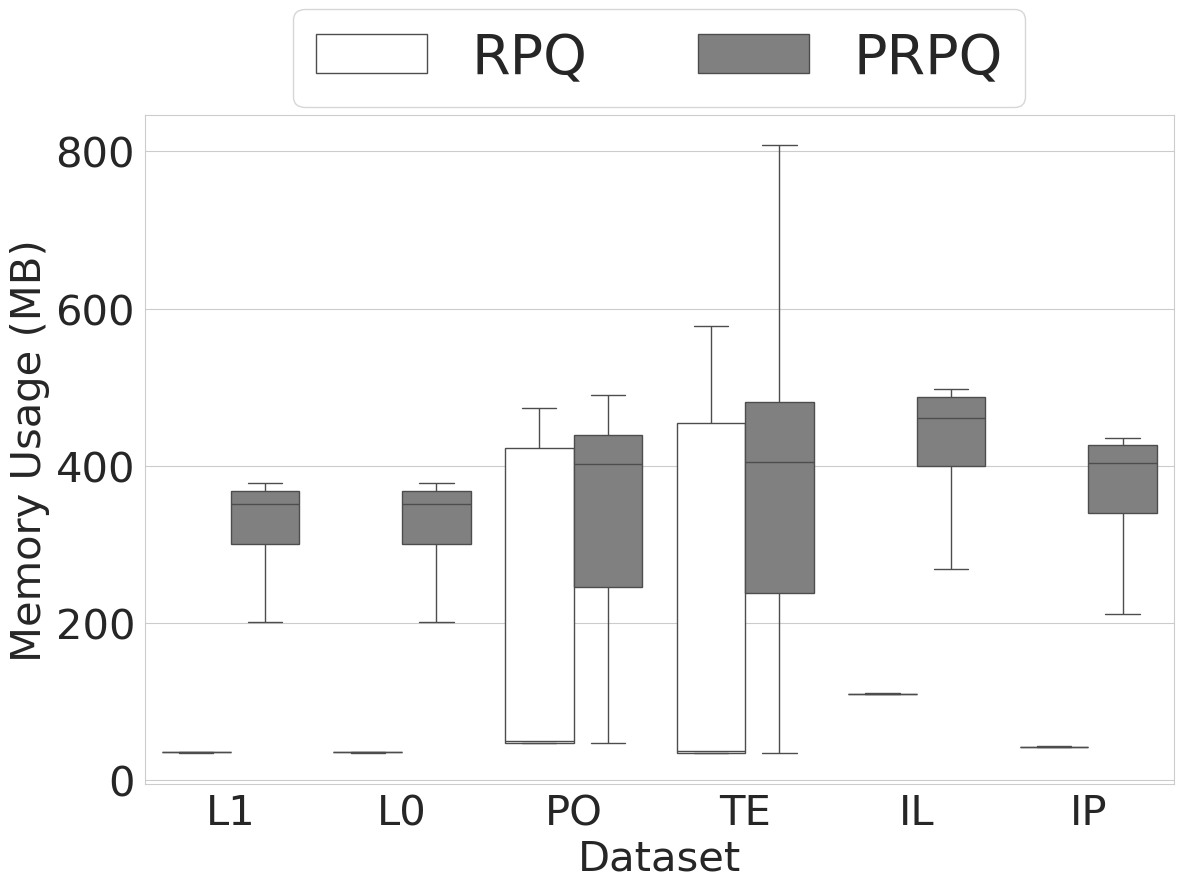

Boxplot saved as: figure/all-dataset-memory-distribution-memory-boxen-comparison.pdf


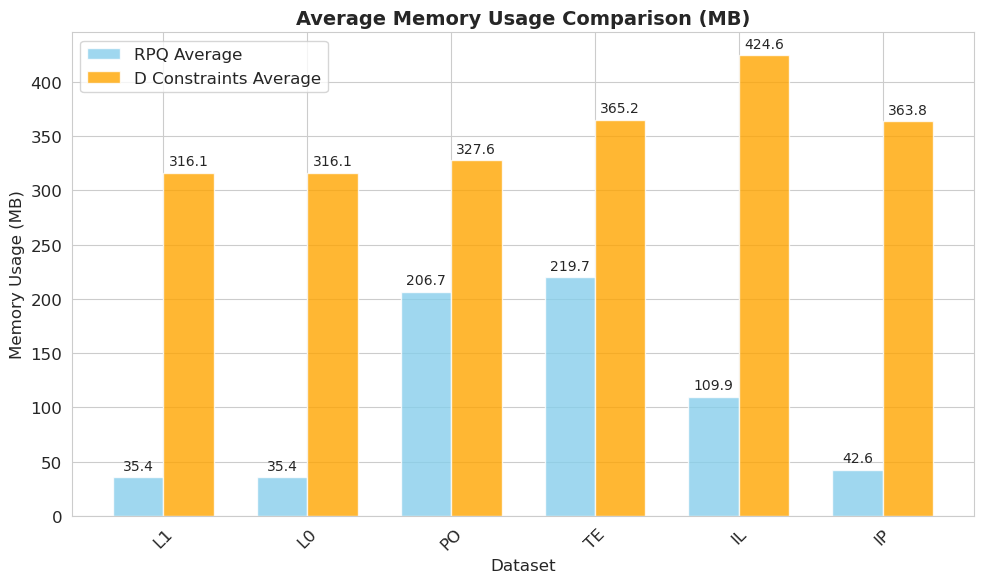

Average memory comparison saved as: figure/all-dataset-memory-distribution-average-memory-comparison.pdf


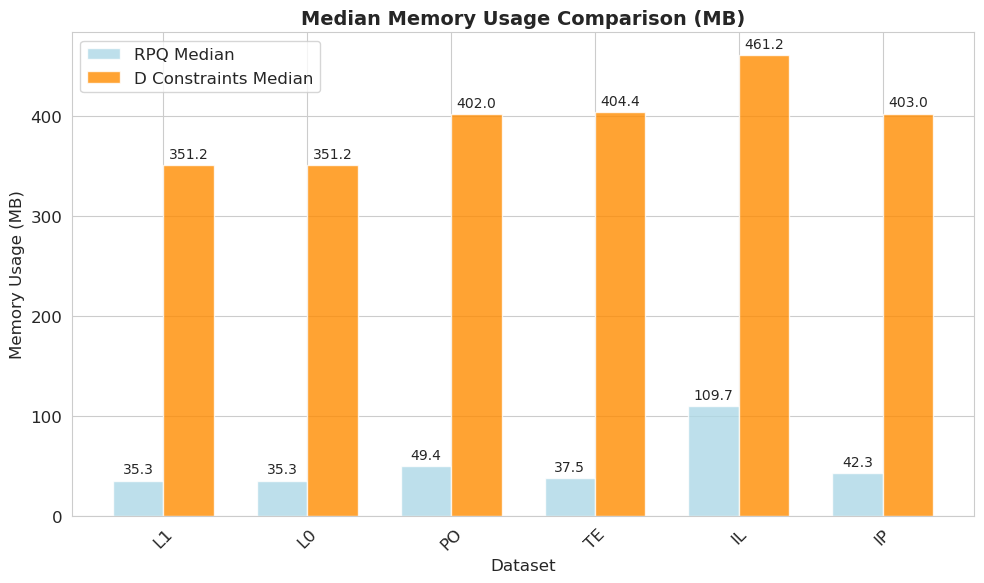

Median memory comparison saved as: figure/all-dataset-memory-distribution-median-memory-comparison.pdf


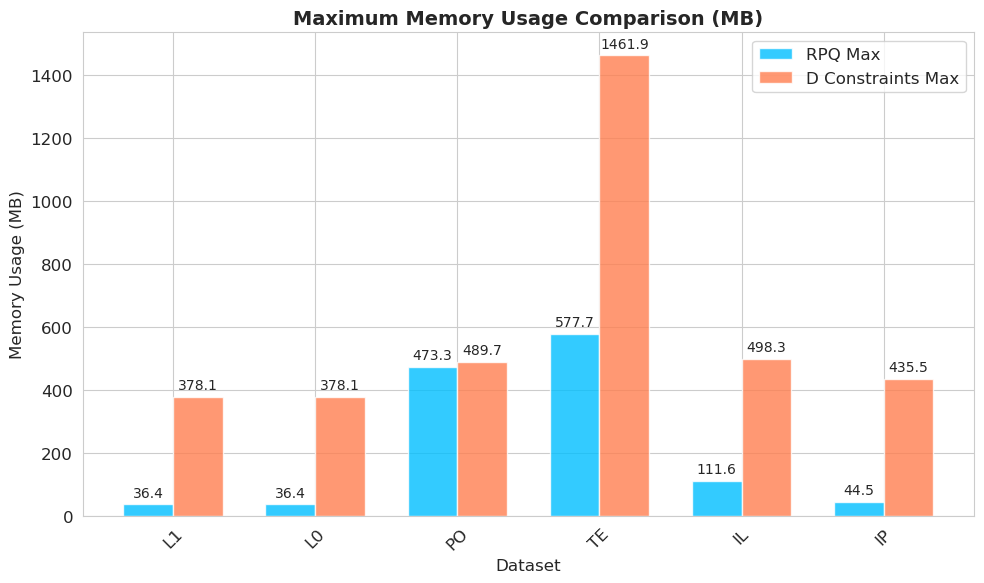

Max memory comparison saved as: figure/all-dataset-memory-distribution-max-memory-comparison.pdf


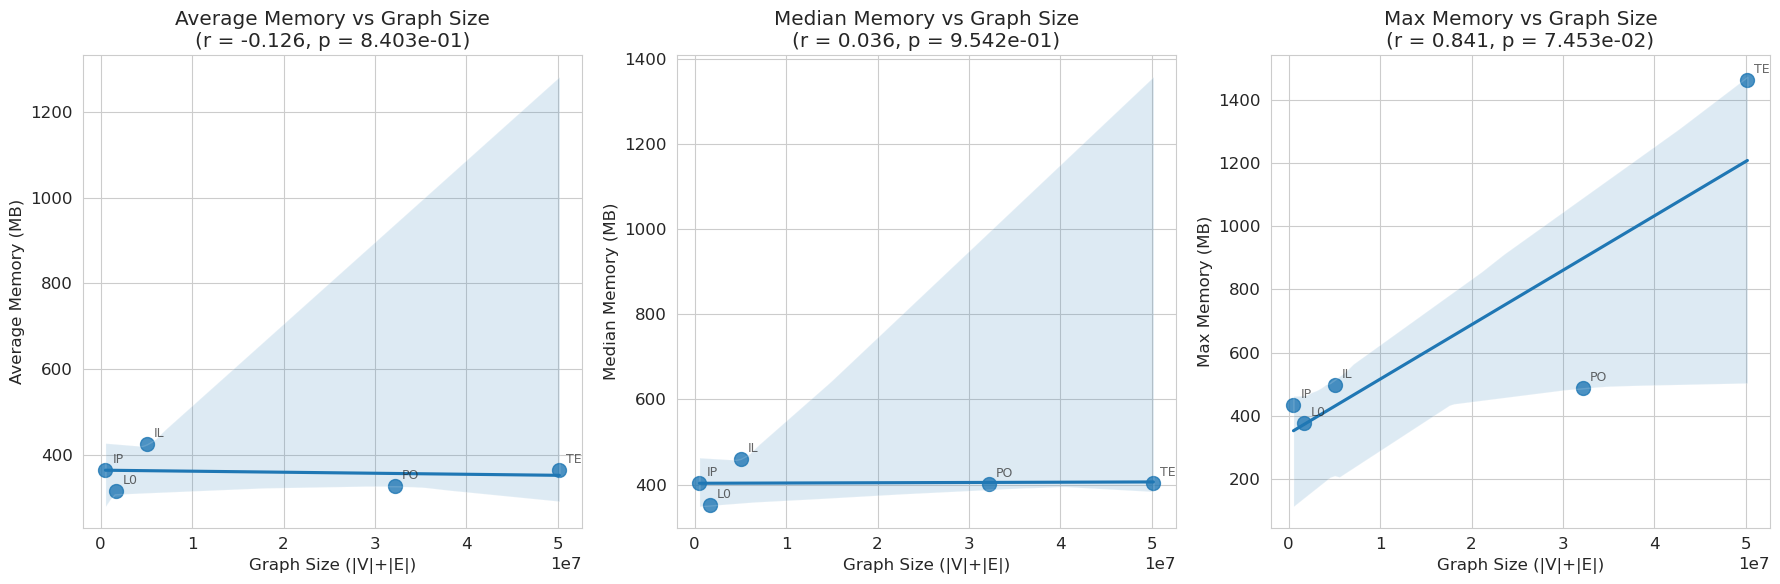

(  Dataset  RPQ Average Memory  D Average Memory  RPQ Median Memory  \
 0      L1           35.411589        316.059271           35.31250   
 1      L0           35.411589        316.059271           35.31250   
 2      PO          206.703804        327.621496           49.37500   
 3      TE          219.718003        365.225664           37.50000   
 4      IL          109.883854        424.569479          109.68750   
 5      IP           42.578906        363.779870           42.34375   
 
    D Median Memory  RPQ Max Memory  D Max Memory  Memory Difference (D-RPQ)  \
 0        351.25000        36.40625    378.125000                 280.647682   
 1        351.25000        36.40625    378.125000                 280.647682   
 2        402.03125       473.28125    489.687500                 120.917692   
 3        404.37500       577.65625   1461.871094                 145.507661   
 4        461.25000       111.56250    498.281250                 314.685625   
 5        402.96875  

In [7]:
from util import *
size = {name: sum(data) for name, data in DATASET_STAT.items()}
plot_dataset_memory_comparison(OPTIMIZED_PATHS.values(), OPTIMIZED_PATHS.keys(), "all-dataset-memory-distribution", size, unit='MB')

In [23]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_algorithm_comparison_by_dataset(optimized_paths, naive_paths, dataset_names, output_name, log_scale=True):
    """
    Plot comparison between optimized and naive algorithms across multiple datasets
    Split by dataset, with queries on x-axis and data constraints as lines
    
    Parameters:
    optimized_paths: list of file paths to optimized algorithm pickle files
    naive_paths: list of file paths to naive algorithm pickle files
    dataset_names: list of dataset names for subplots
    output_name: name for output file
    log_scale: whether to use log scale for y-axis
    """
    
    # Load all datasets
    optimized_data = []
    naive_data = []
    
    for path in optimized_paths:
        with open(path, "rb+") as f:
            data = pickle.loads(f.read())
            optimized_data.append(data)
    
    for path in naive_paths:
        with open(path, "rb+") as f:
            data = pickle.loads(f.read())
            naive_data.append(data)
    
    # Process all datasets
    plot_data = []
    
    # Process optimized algorithms
    for dataset_idx, (data, dataset_name) in enumerate(zip(optimized_data, dataset_names)):
        for i in range(12):  # Q1-Q12
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:  # Skip RPQ
                    id += 1
                    continue
                values = list(map(lambda x: x, data[i*6 + id][2]))
                avg_time = np.mean(values)
                plot_data.append({
                    'Algorithm': 'Optimized',
                    'Dataset': dataset_name,
                    'Query': f"Q{i+1}",
                    'Data Constraint': dtype,
                    'Average Time': avg_time,
                    'Query Number': i + 1  # Numerical value for sorting
                })
                id += 1
    
    # Process naive algorithms
    for dataset_idx, (data, dataset_name) in enumerate(zip(naive_data, dataset_names)):
        for i in range(12):  # Q1-Q12
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:  # Skip RPQ
                    id += 1
                    continue
                values = list(map(lambda x: x, data[i*6 + id][2]))
                avg_time = np.mean(values)
                plot_data.append({
                    'Algorithm': 'Naive',
                    'Dataset': dataset_name,
                    'Query': f"Q{i+1}",
                    'Data Constraint': dtype,
                    'Average Time': avg_time,
                    'Query Number': i + 1  # Numerical value for sorting
                })
                id += 1
    
    df = pd.DataFrame(plot_data)
    
    # Create subplots for each dataset
    n_datasets = len(dataset_names)
    cols = min(3, n_datasets)  # Maximum 3 columns
    rows = (n_datasets + cols - 1) // cols  # Calculate required rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    
    # If only one dataset, make axes an array for consistent indexing
    if n_datasets == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    sns.set_style("whitegrid")
    
    # Get current font sizes to calculate larger size
    current_fontsize = plt.rcParams['font.size']
    larger_fontsize = current_fontsize * 2
    
    # Define colors for data constraints
    constraint_colors = {
        'D1': 'blue',
        'D2': 'green',
        'D3': 'red',
        'D4': 'purple',
        'D5': 'orange'
    }
    
    # Define line styles for algorithms
    algorithm_styles = {'Optimized': '-', 'Naive': '--'}
    
    # Define markers for better distinction
    markers = ['o', 's', 'D', '^', 'v']
    
    # Plot each dataset in a separate subplot
    for dataset_idx, dataset_name in enumerate(dataset_names):
        if dataset_idx >= len(axes):
            break
            
        ax = axes[dataset_idx]
        dataset_df = df[df['Dataset'] == dataset_name]
        
        # Plot each algorithm and data constraint combination
        for algorithm in ['Optimized', 'Naive']:
            algorithm_df = dataset_df[dataset_df['Algorithm'] == algorithm]
            
            for constraint_idx, constraint in enumerate(["D1", "D2", "D3", "D4", "D5"]):
                constraint_algorithm_df = algorithm_df[algorithm_df['Data Constraint'] == constraint]
                
                # Sort by query number
                constraint_algorithm_df = constraint_algorithm_df.sort_values('Query Number')
                
                # Plot line
                line = ax.plot(constraint_algorithm_df['Query'], constraint_algorithm_df['Average Time'],
                             color=constraint_colors[constraint],
                             linestyle=algorithm_styles[algorithm],
                             marker=markers[constraint_idx % len(markers)],
                             markersize=5,
                             linewidth=2.5,
                             label=f'{algorithm} - {constraint}' if dataset_idx == 0 else "",
                             alpha=0.8,
                             markevery=2)  # Show every 2nd marker to reduce clutter
        
        # Set subplot title and labels
        ax.set_title(f"{dataset_name}", fontsize=larger_fontsize, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("Average Time (ms)", fontsize=larger_fontsize * 0.8)
        
        # Increase tick label size
        ax.tick_params(axis='x', labelsize=larger_fontsize * 0.7)
        ax.tick_params(axis='y', labelsize=larger_fontsize * 0.7)
        
        # Rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Check for log scale
        # max_time_val = dataset_df['Average Time'].max()
        # min_time_val = dataset_df[dataset_df['Average Time'] > 0]['Average Time'].min()
        # if log_scale and max_time_val > 0 and min_time_val > 0 and max_time_val / min_time_val > 100:
        #     ax.set_yscale("log")
        #     ax.set_title(f"Dataset: {dataset_name} (Log Scale)", fontsize=larger_fontsize, fontweight='bold')
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3)
        
        # # Add legend to first subplot only to avoid duplication
        # if dataset_idx == 0:
        #     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=larger_fontsize * 0.7)
    
    # Remove empty subplots if any
    for i in range(len(dataset_names), len(axes)):
        fig.delaxes(axes[i])
    
    # Create comprehensive legends outside the plots
    # Constraint legend elements
    constraint_legend_elements = []
    for constraint, color in constraint_colors.items():
        constraint_legend_elements.append(
            plt.Line2D([0], [0], color=color, linestyle='-', 
                      linewidth=3, marker='o', markersize=8, label=constraint)
        )
    
    # Algorithm legend elements
    algorithm_legend_elements = []
    for algorithm, style in algorithm_styles.items():
        algorithm_legend_elements.append(
            plt.Line2D([0], [0], color='black', linestyle=style,
                      linewidth=3, label=algorithm)
        )
    
    # Create legends
    legend1 = fig.legend(handles=constraint_legend_elements,
                        loc='upper center',
                        bbox_to_anchor=(0.3, 1.05),
                        ncol=5,
                        fontsize=larger_fontsize * 0.8,
                        title="Data Constraints",
                        title_fontsize=larger_fontsize)
    
    legend2 = fig.legend(handles=algorithm_legend_elements,
                        loc='upper center',
                        bbox_to_anchor=(0.7, 1.05),
                        ncol=2,
                        fontsize=larger_fontsize * 0.8,
                        title="Algorithms",
                        title_fontsize=larger_fontsize)
    
    # Main title
    # plt.suptitle("Algorithm Comparison: Optimized vs Naive by Dataset", 
    #             fontsize=larger_fontsize * 1.5, fontweight='bold', y=0.98)
    
    # Adjust layout to make room for legends
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    
    # Save figure
    plt.savefig(f'figure/{output_name}-algorithm-comparison-by-dataset.pdf',
               format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()



# Usage example:
# optimized_paths = ["opt1.pkl", "opt2.pkl", "opt3.pkl"]
# naive_paths = ["naive1.pkl", "naive2.pkl", "naive3.pkl"]
# dataset_names = ["Dataset1", "Dataset2", "Dataset3"]
# plot_algorithm_comparison_by_dataset(optimized_paths, naive_paths, dataset_names, "comparison", log_scale=True)

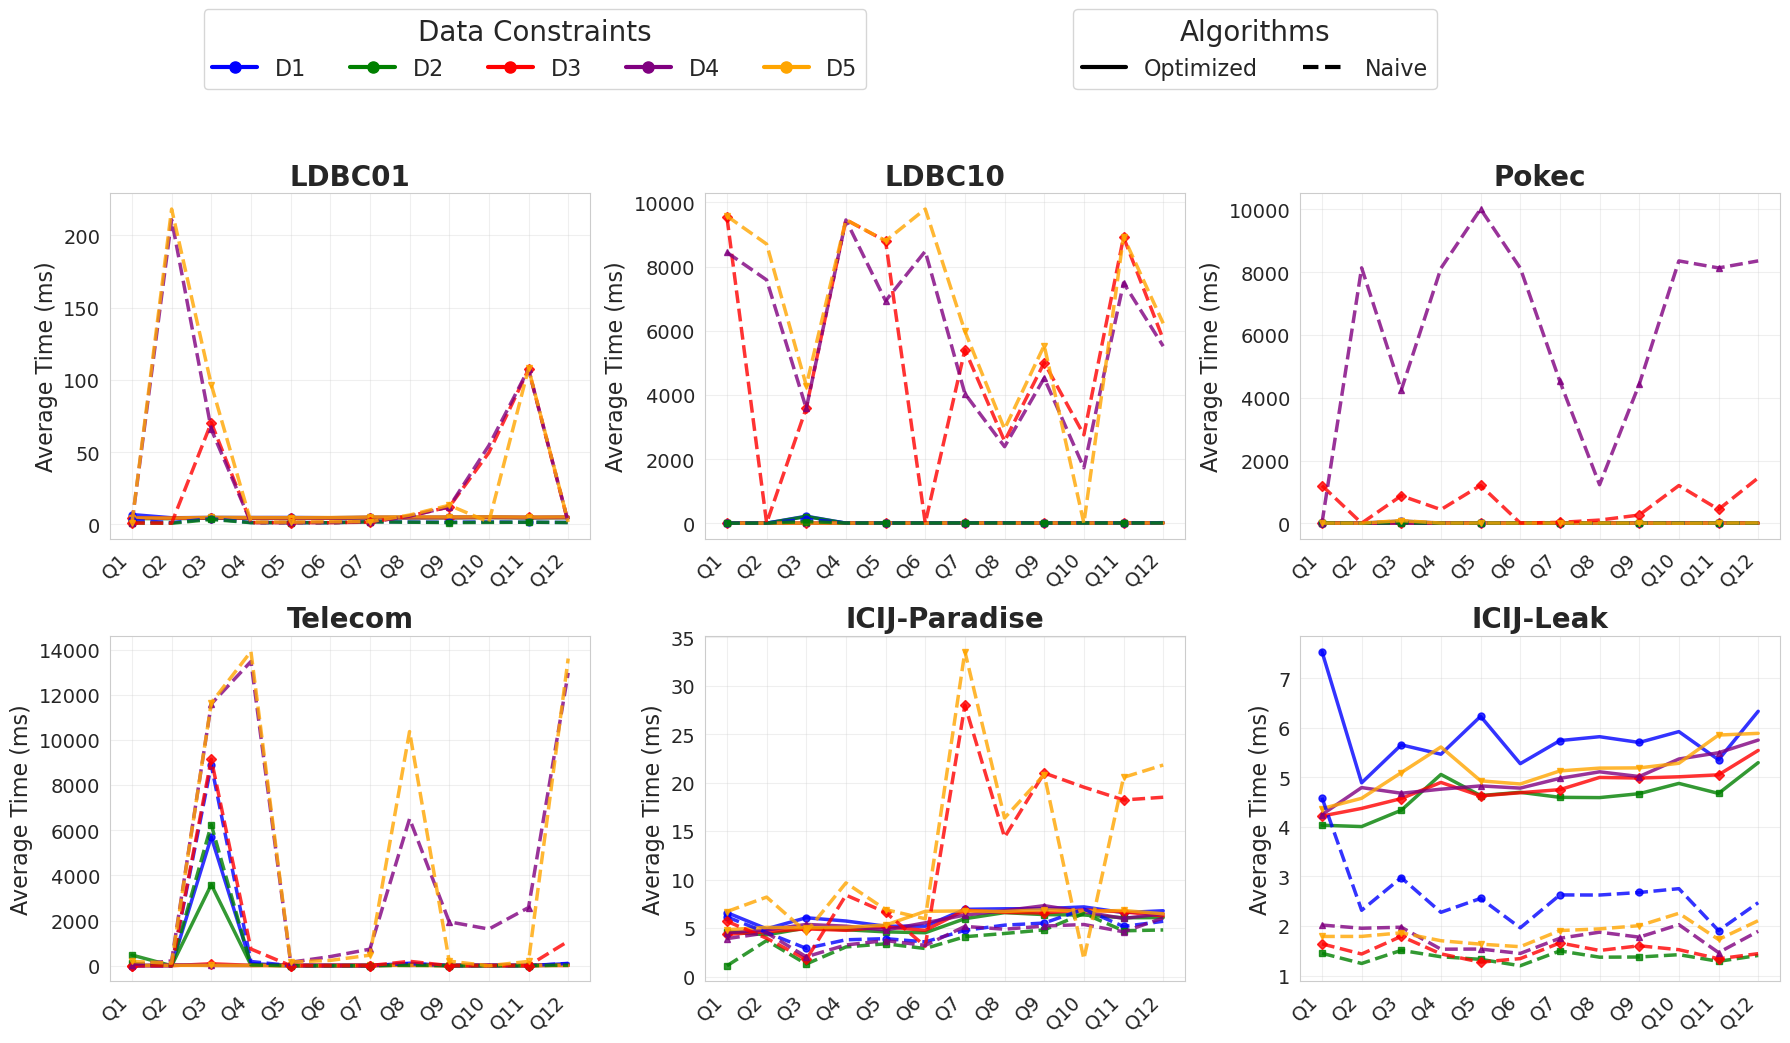

In [24]:
plot_algorithm_comparison_by_dataset(optimized_paths, naive_paths, dataset_names, "all-datasets", log_scale=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import scipy.stats as stats
from matplotlib.ticker import *
from matplotlib.cm import get_cmap
import os

def slice_small_log(path):
    f = open(path, "rb+") 
    count = 0 
    res = []
    d = {}
    for qi in range(12):
        d[f"Q{qi+1}"] = {}
    for line in f:
        if "exploration_depth" in line.decode('utf-8'):
            res.append(int(line.decode('utf-8').split(":")[1].strip()))
    for i in range(12):
        for j in range(5):
            d[f"Q{i+1}"][f"D{j+1}"] = res[i*500 + j*100: i*500 + (j+1)*100]
    return d

def load_running_time_data(path, dataset_name):
    """Load running time data from pickle file"""
    with open(path, "rb+") as f:
        data = pickle.loads(f.read())
    
    time_data = {}
    for i in range(12):  # Q1-Q12
        query_key = f"Q{i+1}"
        time_data[query_key] = {}
        
        id = 0
        for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
            if id == 0:  # Skip RPQ
                id += 1
                continue
            values = list(map(lambda x: x, data[i*6 + id][2]))
            time_data[query_key][dtype] = values
            id += 1
    
    return time_data

def prepare_raw_data(cardinality_data, runtime_data, dataset_name):
    """Prepare raw data points without statistics"""
    plot_data = []
    
    constraints = ['D1', 'D2', 'D3', 'D4', 'D5']
    
    for query_key in cardinality_data.keys():
        for constraint in constraints:
            if (constraint in cardinality_data[query_key] and 
                constraint in runtime_data[query_key]):
                
                # Get all individual data points
                cardinality_points = cardinality_data[query_key][constraint]
                runtime_points = runtime_data[query_key][constraint]
                
                # Make sure we have the same number of points
                min_length = min(len(cardinality_points), len(runtime_points))
                
                for i in range(min_length):
                    plot_data.append({
                        'dataset': dataset_name,
                        'query': query_key,
                        'constraint': constraint,
                        'cardinality': cardinality_points[i],
                        'runtime': runtime_points[i]
                    })
    
    return pd.DataFrame(plot_data)

def plot_individual_dataset_raw(df, dataset_name, log_scale=False):
    """Create raw scatter plot for an individual dataset"""
    
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Get unique constraints for coloring
    constraints = df['constraint'].unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(constraints)))
    color_map = {constraint: color for constraint, color in zip(constraints, colors)}
    
    # Plot each constraint with different color
    for constraint in constraints:
        constraint_df = df[df['constraint'] == constraint]
        ax.scatter(constraint_df['cardinality'], constraint_df['runtime'], 
                  color="grey", s=40, alpha=0.6, 
                  edgecolors='none', label=f'Constraint {constraint}')
    
    # Calculate and display correlation coefficient
    if not df.empty:
        # correlation = np.corrcoef(df['cardinality'], df['runtime'])[0, 1]
        correlation, p = stats.pearsonr(df['cardinality'], df['runtime'])[0:2]
        ax.text(0.05, 0.88, f'Correlation: {correlation:.3f}', 
               transform=ax.transAxes, fontsize=12,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
        
        # Add number of data points
        ax.text(0.05, 0.7, f'Data points: {len(df):,}', 
               transform=ax.transAxes, fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
    
    # Add trend line
    if not df.empty:
        z = np.polyfit(df['cardinality'], df['runtime'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(df['cardinality'].min(), df['cardinality'].max(), 100)
        ax.plot(x_range, p(x_range), 'black', linestyle='-', 
               linewidth=2, alpha=0.8, label='Trend line')
    
    # Set labels and title
    ax.set_xlabel('Cardinality (Exploration Depth)', fontsize=14)
    ax.set_ylabel('Runtime (ms)', fontsize=14)
    ax.set_title(f'Cardinality vs Runtime - {dataset_name}', fontsize=16, pad=20)
    
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10)
    
    # Save figure
    os.makedirs('figure/individual', exist_ok=True)
    fig.savefig(f'figure/individual/{dataset_name}_cardinality_vs_runtime_raw.pdf', 
                bbox_inches='tight', dpi=300)
    
    plt.close(fig)
    
    return correlation

def plot_merged_datasets_raw(all_dfs, log_scale=False):
    """Create merged raw scatter plot across all datasets"""
    
    # Combine all datasets
    merged_df = pd.concat(all_dfs.values(), ignore_index=True)
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Get unique datasets for coloring
    datasets = merged_df['dataset'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(datasets)))
    color_map = {dataset: color for dataset, color in zip(datasets, colors)}
    
    # Plot each dataset with different color
    for dataset in datasets:
        dataset_df = merged_df[merged_df['dataset'] == dataset]
        ax.scatter(dataset_df['cardinality'], dataset_df['runtime'], 
                  color="grey", s=30, alpha=0.5, 
                  edgecolors='none', label=dataset)
    
    # Calculate and display correlation coefficient
    if not merged_df.empty:
        correlation, p = stats.pearsonr(merged_df['cardinality'], merged_df['runtime'])[0:2]
        ax.text(0.05, 0.88, f'Correlation: {correlation:.3f}', 
               transform=ax.transAxes, fontsize=40)
        ax.text(0.05, 0.75, f'P-value: {p:.3e}', transform=ax.transAxes, fontsize=40)
        # Add number of data points
        # ax.text(0.05, 0.88, f'Data points: {len(merged_df):,}', 
        #        transform=ax.transAxes, fontsize=10,
        #        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
    
    # Add trend line
    if not merged_df.empty:
        z = np.polyfit(merged_df['cardinality'], merged_df['runtime'], 2)
        p = np.poly1d(z)
        x_range = np.linspace(merged_df['cardinality'].min(), merged_df['cardinality'].max(), 100)
        ax.plot(x_range, p(x_range), 'black', linestyle='-', 
               linewidth=3, alpha=0.8, label='Overall trend')
    
    # Set labels and title
    ax.set_xlabel('Oracle Query Counts', fontsize=40)
    ax.set_ylabel('Runtime (ms)', fontsize=40)
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)
    # ax.set_title('Cardinality vs Runtime (All Datasets)', fontsize=16, pad=20)
    
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3, linestyle='--')
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    legends = [
        Patch([0], [0], hatch='O', color='grey', label="Individual Run",
               alpha=0.5, linestyle='None'),
        Line2D([0], [0], color='black', lw=3, label='Overall Trend') 
    ]
    ax.legend(handles=legends, fontsize=40, loc='upper left', bbox_to_anchor=(1.05, 1))

    # Save figure
    os.makedirs('figure/merged', exist_ok=True)
    fig.savefig('figure/merged/merged_cardinality_vs_runtime_raw.pdf', 
                bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return merged_df, correlation

def print_correlation_summary(correlation_results):
    """Print summary of correlation coefficients"""
    print("\n" + "="*50)
    print("CORRELATION SUMMARY - RAW DATA POINTS")
    print("="*50)
    
    # Create table header
    print(f"{'Dataset':<15} {'Correlation':<12} {'Data Points':<12}")
    print("-" * 40)
    
    # Print each dataset's correlation
    for dataset, (correlation, data_points) in correlation_results.items():
        print(f"{dataset:<15} {correlation:.4f}      {data_points:,}")
    
    # Calculate average correlation
    avg_correlation = np.mean([corr for corr, _ in correlation_results.values()])
    total_points = sum([points for _, points in correlation_results.values()])
    
    print("-" * 40)
    print(f"{'Average':<15} {avg_correlation:.4f}      {total_points:,}")
    print("="*50)

def plot_all_datasets_raw(cardinality_paths, runtime_paths, log_scale=False):
    """
    Plot raw scatter plots between cardinality and runtime for each dataset
    and then merged together
    
    Parameters:
    -----------
    cardinality_paths : dict
        Dictionary of {dataset_name: cardinality_file_path}
    runtime_paths : dict
        Dictionary of {dataset_name: runtime_file_path}
    log_scale : bool
        Whether to use logarithmic scale
    """
    
    all_dfs = {}
    correlation_results = {}
    
    print("Processing individual datasets (raw data points)...")
    for dataset_name in cardinality_paths.keys():
        if dataset_name in runtime_paths:
            print(f"  Analyzing {dataset_name}...")
            
            # Load data
            cardinality_data = slice_small_log(cardinality_paths[dataset_name])
            runtime_data = load_running_time_data(runtime_paths[dataset_name], dataset_name)
            
            # Prepare raw data
            df = prepare_raw_data(cardinality_data, runtime_data, dataset_name)
            all_dfs[dataset_name] = df
            
            # Plot individual dataset
            correlation = plot_individual_dataset_raw(df, dataset_name, log_scale)
            correlation_results[dataset_name] = (correlation, len(df))
            
            print(f"    {dataset_name}: {len(df):,} data points, correlation: {correlation:.3f}")
    
    # Print correlation summary
    print_correlation_summary(correlation_results)
    
    # Plot merged datasets
    print("\nCreating merged raw plot...")
    merged_df, merged_correlation = plot_merged_datasets_raw(all_dfs, log_scale)
    
    print(f"\nTotal data points across all datasets: {len(merged_df):,}")
    print(f"Overall correlation: {merged_correlation:.3f}")
    print("Analysis complete! Check the 'figure/' directory for plots.")

# Example usage:
# cardinality_paths = {
#     "DBPedia": "path/to/dbpedia_cardinality.log",
#     "YAGO": "path/to/yago_cardinality.log",
#     "Wikidata": "path/to/wikidata_cardinality.log"
# }
#
# runtime_paths = {
#     "DBPedia": "path/to/dbpedia_runtime.pkl",
#     "YAGO": "path/to/yago_runtime.pkl",
#     "Wikidata": "path/to/wikidata_runtime.pkl"
# }
#
# plot_all_datasets_raw(cardinality_paths, runtime_paths, log_scale=True)

In [24]:
import os

def slice_small_log(path):
    f = open(path, "rb+") 
    count = 0 
    res = []
    d = {}
    for qi in range(12):
        d[f"Q{qi+1}"] = {}
    for line in f:
        if "exploration_depth" in line.decode('utf-8'):
            res.append(int(line.decode('utf-8').split(":")[1].strip()))
    for i in range(12):
        for j in range(5):
            d[f"Q{i+1}"][f"D{j+1}"] = res[i*500 + j*100: i*500 + (j+1)*100]
    return d

def load_running_time_data(path, dataset_name):
    """Load running time data from pickle file"""
    with open(path, "rb+") as f:
        data = pickle.loads(f.read())
    
    time_data = {}
    for i in range(12):  # Q1-Q12
        query_key = f"Q{i+1}"
        time_data[query_key] = {}
        
        id = 0
        for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
            if id == 0:  # Skip RPQ
                id += 1
                continue
            values = list(map(lambda x: x, data[i*6 + id][2]))
            time_data[query_key][dtype] = values
            id += 1
    
    return time_data

def prepare_raw_data(cardinality_data, runtime_data, dataset_name):
    """Prepare raw data points without statistics"""
    plot_data = []
    
    constraints = ['D1', 'D2', 'D3', 'D4', 'D5']
    
    for query_key in cardinality_data.keys():
        for constraint in constraints:
            if (constraint in cardinality_data[query_key] and 
                constraint in runtime_data[query_key]):
                
                # Get all individual data points
                cardinality_points = cardinality_data[query_key][constraint]
                runtime_points = runtime_data[query_key][constraint]
                
                # Make sure we have the same number of points
                min_length = min(len(cardinality_points), len(runtime_points))
                
                for i in range(min_length):
                    plot_data.append({
                        'dataset': dataset_name,
                        'query': query_key,
                        'constraint': constraint,
                        'cardinality': cardinality_points[i],
                        'runtime': runtime_points[i]
                    })
    
    return pd.DataFrame(plot_data)

def plot_individual_dataset_raw(df, dataset_name, log_scale=False):
    """Create raw scatter plot for an individual dataset"""
    
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Get unique constraints for coloring
    constraints = df['constraint'].unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(constraints)))
    color_map = {constraint: color for constraint, color in zip(constraints, colors)}
    
    # Plot each constraint with different color
    for constraint in constraints:
        constraint_df = df[df['constraint'] == constraint]
        ax.scatter(constraint_df['cardinality'], constraint_df['runtime'], 
                  color="grey", s=40, alpha=0.6, 
                  edgecolors='none', label=f'Constraint {constraint}')
    
    # Calculate and display correlation coefficient
    if not df.empty:
        # correlation = np.corrcoef(df['cardinality'], df['runtime'])[0, 1]
        correlation, p = stats.pearsonr(df['cardinality'], df['runtime'])[0:2]
        ax.text(0.05, 0.88, f'Correlation: {correlation:.3f}', 
               transform=ax.transAxes, fontsize=12,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
        
        # Add number of data points
        ax.text(0.05, 0.7, f'Data points: {len(df):,}', 
               transform=ax.transAxes, fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
    
    # Add trend line
    if not df.empty:
        z = np.polyfit(df['cardinality'], df['runtime'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(df['cardinality'].min(), df['cardinality'].max(), 100)
        ax.plot(x_range, p(x_range), 'black', linestyle='-', 
               linewidth=2, alpha=0.8, label='Trend line')
    
    # Set labels and title
    ax.set_xlabel('Cardinality (Exploration Depth)', fontsize=14)
    ax.set_ylabel('Runtime (ms)', fontsize=14)
    ax.set_title(f'Cardinality vs Runtime - {dataset_name}', fontsize=16, pad=20)
    
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10)
    
    # Save figure
    os.makedirs('figure/individual', exist_ok=True)
    fig.savefig(f'figure/individual/{dataset_name}_cardinality_vs_runtime_raw.pdf', 
                bbox_inches='tight', dpi=300)
    
    plt.close(fig)
    
    return correlation

def plot_merged_datasets_raw(all_dfs, log_scale=False):
    """Create merged raw scatter plot across all datasets"""
    
    # Combine all datasets
    merged_df = pd.concat(all_dfs.values(), ignore_index=True)
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Get unique datasets for coloring
    datasets = merged_df['dataset'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(datasets)))
    color_map = {dataset: color for dataset, color in zip(datasets, colors)}
    
    # Plot each dataset with different color
    for dataset in datasets:
        dataset_df = merged_df[merged_df['dataset'] == dataset]
        ax.scatter(dataset_df['cardinality'], dataset_df['runtime'], 
                  color="grey", s=30, alpha=0.5, 
                  edgecolors='none', label=dataset)
    
    # Calculate and display correlation coefficient
    if not merged_df.empty:
        correlation, p = stats.pearsonr(merged_df['cardinality'], merged_df['runtime'])[0:2]
        ax.text(0.05, 0.88, f'r: {correlation:.3f}', 
               transform=ax.transAxes, fontsize=40)
        ax.text(0.05, 0.75, f'p < 0.001 ' if p < 0.001 else f'p: {p:.3e}', transform=ax.transAxes, fontsize=40)
        # Add number of data points
        # ax.text(0.05, 0.88, f'Data points: {len(merged_df):,}', 
        #        transform=ax.transAxes, fontsize=10,
        #        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
    
    # Add trend line
    if not merged_df.empty:
        z = np.polyfit(merged_df['cardinality'], merged_df['runtime'], 2)
        p = np.poly1d(z)
        x_range = np.linspace(merged_df['cardinality'].min(), merged_df['cardinality'].max(), 100)
        ax.plot(x_range, p(x_range), 'black', linestyle='-', 
               linewidth=3, alpha=0.8, label='Overall trend')
    
    # Set labels and title
    ax.set_xlabel('Oracle Query Counts', fontsize=40)
    ax.set_ylabel('Runtime (ms)', fontsize=40)
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)
    # ax.set_title('Cardinality vs Runtime (All Datasets)', fontsize=16, pad=20)
    
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3, linestyle='--')
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    legends = [
        Patch([0], [0], hatch='O', color='grey', label="Individual Run",
               alpha=0.5, linestyle='None'),
        Line2D([0], [0], color='black', lw=3, label='Overall Trend') 
    ]
    ax.legend(handles=legends, fontsize=40, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)

    # Save figure
    os.makedirs('figure/merged', exist_ok=True)
    fig.savefig('figure/merged/merged_cardinality_vs_runtime_raw.pdf', 
                bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return merged_df, correlation

def print_correlation_summary(correlation_results):
    """Print summary of correlation coefficients"""
    print("\n" + "="*50)
    print("CORRELATION SUMMARY - RAW DATA POINTS")
    print("="*50)
    
    # Create table header
    print(f"{'Dataset':<15} {'Correlation':<12} {'Data Points':<12}")
    print("-" * 40)
    
    # Print each dataset's correlation
    for dataset, (correlation, data_points) in correlation_results.items():
        print(f"{dataset:<15} {correlation:.4f}      {data_points:,}")
    
    # Calculate average correlation
    avg_correlation = np.mean([corr for corr, _ in correlation_results.values()])
    total_points = sum([points for _, points in correlation_results.values()])
    
    print("-" * 40)
    print(f"{'Average':<15} {avg_correlation:.4f}      {total_points:,}")
    print("="*50)

def plot_all_datasets_raw(cardinality_paths, runtime_paths, log_scale=False):
    """
    Plot raw scatter plots between cardinality and runtime for each dataset
    and then merged together
    
    Parameters:
    -----------
    cardinality_paths : dict
        Dictionary of {dataset_name: cardinality_file_path}
    runtime_paths : dict
        Dictionary of {dataset_name: runtime_file_path}
    log_scale : bool
        Whether to use logarithmic scale
    """
    
    all_dfs = {}
    correlation_results = {}
    
    print("Processing individual datasets (raw data points)...")
    for dataset_name in cardinality_paths.keys():
        if dataset_name in runtime_paths:
            print(f"  Analyzing {dataset_name}...")
            
            # Load data
            cardinality_data = slice_small_log(cardinality_paths[dataset_name])
            runtime_data = load_running_time_data(runtime_paths[dataset_name], dataset_name)
            
            # Prepare raw data
            df = prepare_raw_data(cardinality_data, runtime_data, dataset_name)
            all_dfs[dataset_name] = df
            
            # Plot individual dataset
            correlation = plot_individual_dataset_raw(df, dataset_name, log_scale)
            correlation_results[dataset_name] = (correlation, len(df))
            
            print(f"    {dataset_name}: {len(df):,} data points, correlation: {correlation:.3f}")
    
    # Print correlation summary
    print_correlation_summary(correlation_results)
    
    # Plot merged datasets
    print("\nCreating merged raw plot...")
    merged_df, merged_correlation = plot_merged_datasets_raw(all_dfs, log_scale)
    
    print(f"\nTotal data points across all datasets: {len(merged_df):,}")
    print(f"Overall correlation: {merged_correlation:.3f}")
    print("Analysis complete! Check the 'figure/' directory for plots.")

# Example usage:
# cardinality_paths = {
#     "DBPedia": "path/to/dbpedia_cardinality.log",
#     "YAGO": "path/to/yago_cardinality.log",
#     "Wikidata": "path/to/wikidata_cardinality.log"
# }
#
# runtime_paths = {
#     "DBPedia": "path/to/dbpedia_runtime.pkl",
#     "YAGO": "path/to/yago_runtime.pkl",
#     "Wikidata": "path/to/wikidata_runtime.pkl"
# }
#
# plot_all_datasets_raw(cardinality_paths, runtime_paths, log_scale=True)

Processing individual datasets (raw data points)...
  Analyzing LDBC10...
    LDBC10: 6,000 data points, correlation: -0.019
  Analyzing LDBC01...
    LDBC01: 6,000 data points, correlation: 0.152
  Analyzing Pokec...
    Pokec: 6,000 data points, correlation: 0.921
  Analyzing Telecom...
    Telecom: 6,000 data points, correlation: 0.972
  Analyzing ICIJ-Leak...
    ICIJ-Leak: 6,000 data points, correlation: 0.573
  Analyzing ICIJ-Paradise...
    ICIJ-Paradise: 6,000 data points, correlation: 0.461

CORRELATION SUMMARY - RAW DATA POINTS
Dataset         Correlation  Data Points 
----------------------------------------
LDBC10          -0.0188      6,000
LDBC01          0.1517      6,000
Pokec           0.9206      6,000
Telecom         0.9718      6,000
ICIJ-Leak       0.5732      6,000
ICIJ-Paradise   0.4608      6,000
----------------------------------------
Average         0.5099      36,000

Creating merged raw plot...


/tmp/ipykernel_19578/1618339979.py:183: MatplotlibDeprecationWarning: Passing the edgecolor parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  Patch([0], [0], hatch='O', color='grey', label="Individual Run",
/tmp/ipykernel_19578/1618339979.py:183: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([0], [0], hatch='O', color='grey', label="Individual Run",


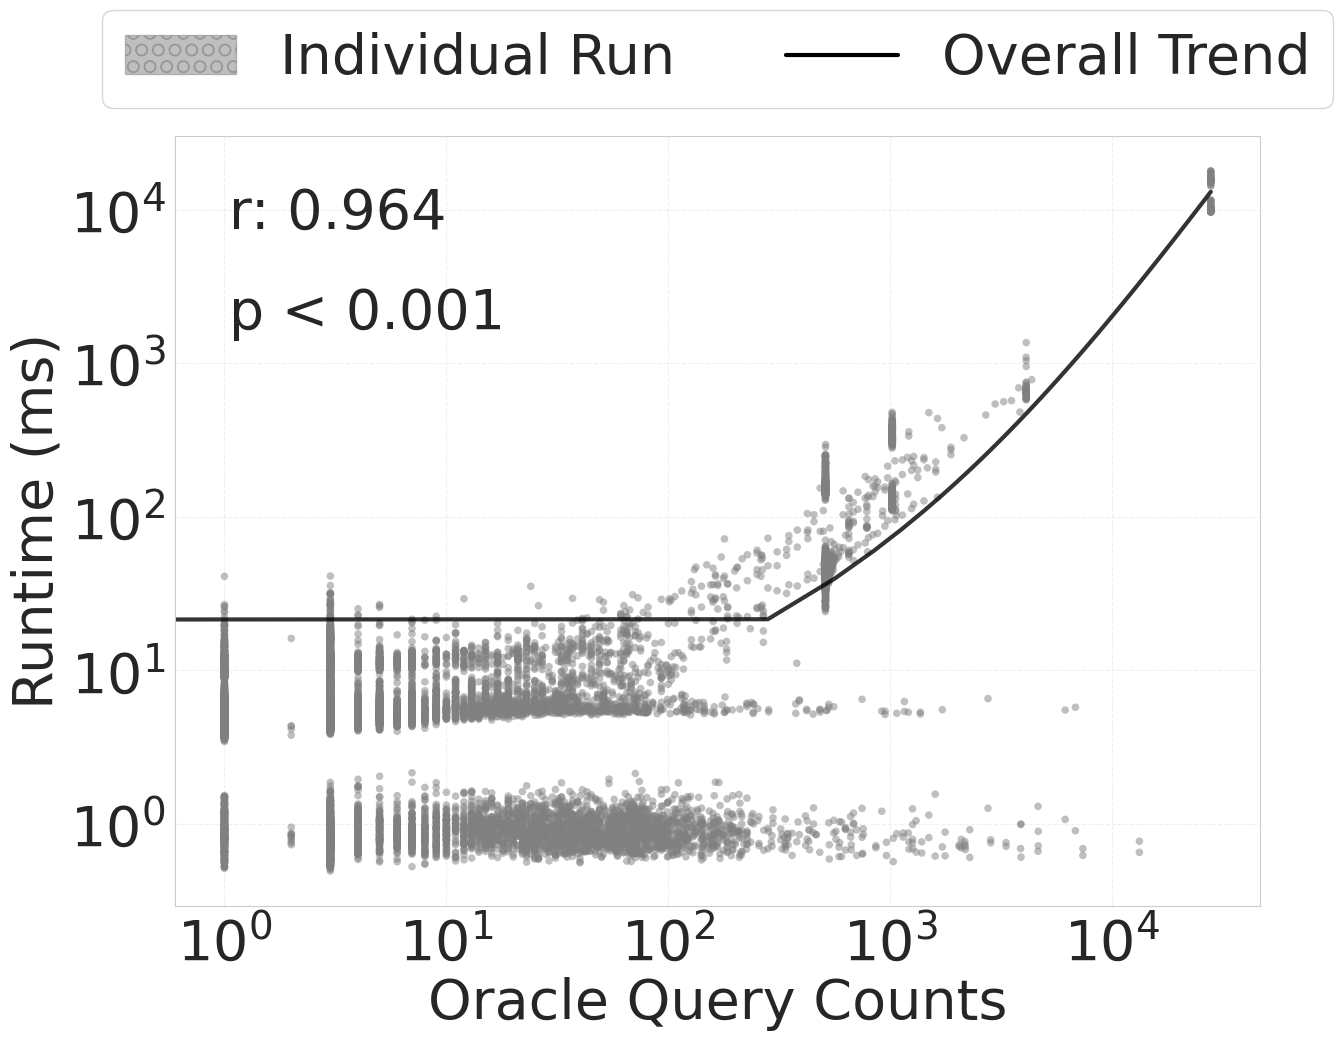


Total data points across all datasets: 36,000
Overall correlation: 0.964
Analysis complete! Check the 'figure/' directory for plots.


In [25]:
dataset_paths = {
        "LDBC10": "ldbc10/z3_debug.log",
        "LDBC01": "ldbc01/z3_debug.log", 
        "Pokec": "pokec/z3_debug.log",
        "Telecom": "telecom/z3_debug.log",
        "ICIJ-Leak": "icij-leak/z3_debug.log",
        "ICIJ-Paradise": "paradise/z3_debug.log"
    }
    
optimized_paths = {"LDBC10":"ldbc01/ldbc01_statistic.pkl", 
         "LDBC01":"ldbc01/ldbc01_statistic.pkl", 
         "Pokec":"pokec/pokec_statistic.pkl",
         "Telecom":"telecom/telecom_statistic.pkl",
         "ICIJ-Leak":"icij-leak/icij_leak_statistic.pkl",
         "ICIJ-Paradise":"paradise/icij_paradise_statistic.pkl"}

dataset_stat ={
            "LDBC10": (30000000, 178000000),
        "LDBC01": (180000, 1500000), 
        "Pokec": (1600000, 30600000),
        "Telecom": (170000, 50000000),
        "ICIJ-Leak": (1900000, 3200000),
        "ICIJ-Paradise": (163000, 364000)
}
    # Plot comparison
plot_all_datasets_raw(dataset_paths, optimized_paths,  log_scale=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import scipy.stats as stats
from matplotlib.ticker import *
from matplotlib.cm import get_cmap
import os


def slice_small_log(path):
    f = open(path, "rb+") 
    count = 0 
    res = []
    d = {}
    for qi in range(12):
        d[f"Q{qi+1}"] = {}
    for line in f:
        if "exploration_depth" in line.decode('utf-8'):
            res.append(int(line.decode('utf-8').split(":")[1].strip()))
    for i in range(12):
        for j in range(5):
            d[f"Q{i+1}"][f"D{j+1}"] = res[i*500 + j*100: i*500 + (j+1)*100]
    return d

def load_running_time_data(path, dataset_name):
    """Load running time data from pickle file"""
    with open(path, "rb+") as f:
        data = pickle.loads(f.read())
    
    time_data = {}
    for i in range(12):  # Q1-Q12
        query_key = f"Q{i+1}"
        time_data[query_key] = {}
        
        id = 0
        for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
            if id == 0:  # Skip RPQ
                id += 1
                continue
            values = list(map(lambda x: x, data[i*6 + id][3]))
            time_data[query_key][dtype] = values
            id += 1
    
    return time_data

def prepare_raw_data(cardinality_data, runtime_data, dataset_name):
    """Prepare raw data points without statistics"""
    plot_data = []
    
    constraints = ['D1', 'D2', 'D3', 'D4', 'D5']
    
    for query_key in cardinality_data.keys():
        for constraint in constraints:
            if (constraint in cardinality_data[query_key] and 
                constraint in runtime_data[query_key]):
                
                # Get all individual data points
                cardinality_points = cardinality_data[query_key][constraint]
                runtime_points = runtime_data[query_key][constraint]
                
                # Make sure we have the same number of points
                min_length = min(len(cardinality_points), len(runtime_points))
                
                for i in range(min_length):
                    plot_data.append({
                        'dataset': dataset_name,
                        'query': query_key,
                        'constraint': constraint,
                        'cardinality': cardinality_points[i],
                        'runtime': runtime_points[i]
                    })
    
    return pd.DataFrame(plot_data)



def plot_merged_datasets_raw(all_dfs, log_scale=False):
    """Create merged raw scatter plot across all datasets"""
    
    # Combine all datasets
    merged_df = pd.concat(all_dfs.values(), ignore_index=True)
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Get unique datasets for coloring
    datasets = merged_df['dataset'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(datasets)))
    color_map = {dataset: color for dataset, color in zip(datasets, colors)}
    
    # Plot each dataset with different color
    for dataset in datasets:
        dataset_df = merged_df[merged_df['dataset'] == dataset]
        ax.scatter(dataset_df['cardinality'], dataset_df['runtime'], 
                  color="grey", s=30, alpha=0.5, 
                  edgecolors='none', label=dataset)
    
    # Calculate and display correlation coefficient
    if not merged_df.empty:
        correlation, p = stats.pearsonr(merged_df['cardinality'].median, merged_df['runtime'])[0:2]
        ax.text(0.05, 0.88, f'Correlation: {correlation:.3f}', 
               transform=ax.transAxes, fontsize=40)
        ax.text(0.05, 0.75, f'P-value: {p:.3e}', transform=ax.transAxes, fontsize=40)
        # Add number of data points
        # ax.text(0.05, 0.88, f'Data points: {len(merged_df):,}', 
        #        transform=ax.transAxes, fontsize=10,
        #        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
    
    # Add trend line
    if not merged_df.empty:
        z = np.polyfit(merged_df['cardinality'], merged_df['runtime'], 2)
        p = np.poly1d(z)
        x_range = np.linspace(merged_df['cardinality'].min(), merged_df['cardinality'].max(), 100)
        ax.plot(x_range, p(x_range), 'black', linestyle='-', 
               linewidth=3, alpha=0.8, label='Overall trend')
    
    # Set labels and title
    ax.set_xlabel('Oracle Query Counts', fontsize=40)
    ax.set_ylabel('Runtime (ms)', fontsize=40)
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)
    # ax.set_title('Cardinality vs Runtime (All Datasets)', fontsize=16, pad=20)
    
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3, linestyle='--')
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    legends = [
        Patch([0], [0], hatch='O', color='grey', label="Individual Run",
               alpha=0.5, linestyle='None'),
        Line2D([0], [0], color='black', lw=3, label='Overall Trend') 
    ]
    ax.legend(handles=legends, fontsize=40, loc='upper left', bbox_to_anchor=(1.05, 1))

    # Save figure
    os.makedirs('figure/merged', exist_ok=True)
    fig.savefig('figure/merged/merged_cardinality_vs_mem_raw.pdf', 
                bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return merged_df, correlation

def print_correlation_summary(correlation_results):
    """Print summary of correlation coefficients"""
    print("\n" + "="*50)
    print("CORRELATION SUMMARY - RAW DATA POINTS")
    print("="*50)
    
    # Create table header
    print(f"{'Dataset':<15} {'Correlation':<12} {'Data Points':<12}")
    print("-" * 40)
    
    # Print each dataset's correlation
    for dataset, (correlation, data_points) in correlation_results.items():
        print(f"{dataset:<15} {correlation:.4f}      {data_points:,}")
    
    # Calculate average correlation
    avg_correlation = np.mean([corr for corr, _ in correlation_results.values()])
    total_points = sum([points for _, points in correlation_results.values()])
    
    print("-" * 40)
    print(f"{'Average':<15} {avg_correlation:.4f}      {total_points:,}")
    print("="*50)

def plot_all_datasets_memory(cardinality_paths, runtime_paths, log_scale=False):
    """
    Plot raw scatter plots between cardinality and runtime for each dataset
    and then merged together
    
    Parameters:
    -----------
    cardinality_paths : dict
        Dictionary of {dataset_name: cardinality_file_path}
    runtime_paths : dict
        Dictionary of {dataset_name: runtime_file_path}
    log_scale : bool
        Whether to use logarithmic scale
    """
    
    all_dfs = {}
    correlation_results = {}
    
    print("Processing individual datasets (raw data points)...")
    for dataset_name in cardinality_paths.keys():
        if dataset_name in runtime_paths:
            print(f"  Analyzing {dataset_name}...")
            
            # Load data
            cardinality_data = slice_small_log(cardinality_paths[dataset_name])
            runtime_data = load_running_time_data(runtime_paths[dataset_name], dataset_name)
            
            # Prepare raw data
            df = prepare_raw_data(cardinality_data, runtime_data, dataset_name)
            all_dfs[dataset_name] = df
    
    # Print correlation summary
    print_correlation_summary(correlation_results)
    
    # Plot merged datasets
    print("\nCreating merged raw plot...")
    merged_df, merged_correlation = plot_merged_datasets_raw(all_dfs, log_scale)
    
    print(f"\nTotal data points across all datasets: {len(merged_df):,}")
    print(f"Overall correlation: {merged_correlation:.3f}")
    print("Analysis complete! Check the 'figure/' directory for plots.")

# Example usage:
# cardinality_paths = {
#     "DBPedia": "path/to/dbpedia_cardinality.log",
#     "YAGO": "path/to/yago_cardinality.log",
#     "Wikidata": "path/to/wikidata_cardinality.log"
# }
#
# runtime_paths = {
#     "DBPedia": "path/to/dbpedia_runtime.pkl",
#     "YAGO": "path/to/yago_runtime.pkl",
#     "Wikidata": "path/to/wikidata_runtime.pkl"
# }
#
# plot_all_datasets_raw(cardinality_paths, runtime_paths, log_scale=True)

Processing individual datasets (raw data points)...
  Analyzing LDBC10...
  Analyzing LDBC01...
  Analyzing Pokec...
  Analyzing Telecom...
  Analyzing ICIJ-Leak...
  Analyzing ICIJ-Paradise...

CORRELATION SUMMARY - RAW DATA POINTS
Dataset         Correlation  Data Points 
----------------------------------------
----------------------------------------
Average         nan      0

Creating merged raw plot...


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TypeError: object of type 'float' has no len()

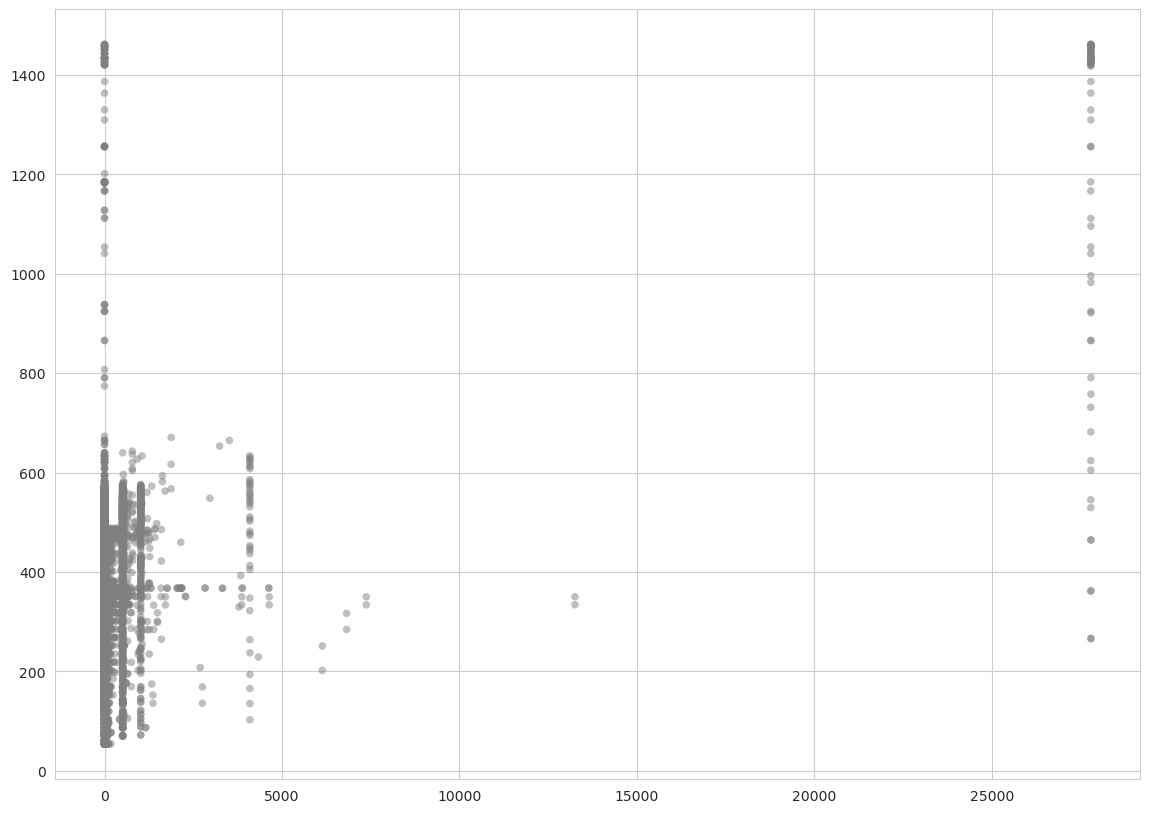

In [27]:
dataset_paths = {
        "LDBC10": "ldbc10/z3_debug.log",
        "LDBC01": "ldbc01/z3_debug.log", 
        "Pokec": "pokec/z3_debug.log",
        "Telecom": "telecom/z3_debug.log",
        "ICIJ-Leak": "icij-leak/z3_debug.log",
        "ICIJ-Paradise": "paradise/z3_debug.log"
    }
    
optimized_paths = {"LDBC10":"ldbc01/ldbc01_statistic.pkl", 
         "LDBC01":"ldbc01/ldbc01_statistic.pkl", 
         "Pokec":"pokec/pokec_statistic.pkl",
         "Telecom":"telecom/telecom_statistic.pkl",
         "ICIJ-Leak":"icij-leak/icij_leak_statistic.pkl",
         "ICIJ-Paradise":"paradise/icij_paradise_statistic.pkl"}

dataset_stat ={
            "LDBC10": (30000000, 178000000),
        "LDBC01": (180000, 1500000), 
        "Pokec": (1600000, 30600000),
        "Telecom": (170000, 50000000),
        "ICIJ-Leak": (1900000, 3200000),
        "ICIJ-Paradise": (163000, 364000)
}
plot_all_datasets_memory(dataset_paths, optimized_paths,  log_scale=True)